# Modeling of Condensation Heat Transfer inside Horizontal Smooth Tubes

## Purpose and Scope
This file contains the machine learning code used in the paper:

**"Modelling of condensation heat transfer inside horizontal smooth tubes: A machine learning based predictive approach"**

The implementation is provided to support transparency,
reproducibility, and further academic research.

## Responsible Use
This code is intended for research and educational use.
The authors assume no liability for misuse or misinterpretation
of the results.

## Citation
If you use this code or build upon it, please cite:

[Nakul Neupane, Sudharshan Saranathan, Sandeep Koundinya, Satyanarayanan Seshadri,
Modelling of condensation heat transfer inside horizontal smooth tubes: A machine learning based predictive approach,
International Communications in Heat and Mass Transfer,
Volume 172, Part 5,
2026,
110556,
ISSN 0735-1933,
https://doi.org/10.1016/j.icheatmasstransfer.2026.110556.]


## Importing Libraries

In [ ]:
import math
import pandas as pd
import numpy as np
import random
import time
import os
import joblib
import keras
import optuna

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker 
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
#import statsmodels.api as sm
from scipy.optimize import fsolve
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from skopt import BayesSearchCV
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, make_scorer
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, models

## Creating a Database with REFPROP

In [ ]:
def cool(ref1, ref2, ref3, ref4, mf1, mf2, mf3, mf4, out, in1, valin1, in2, valin2):
    a = ref1
    b = ref2
    h = ref3
    j = ref4
    c = mf1
    d = mf2
    i = mf3
    m = mf4

    if b == 0:
        k = 'REFPROP::' + a
        g = CP.PropsSI(out, in1, valin1, in2, valin2, k)
        return g
    elif h == 0:
        e = a + '&' + b
        y = CP.AbstractState('REFPROP', e)
        y.set_mass_fractions([c, d])
        f = y.get_mole_fractions()
        k = 'REFPROP::' + a + '[' + "{}".format(f[0]) + ']' + '&' + b + '[' + "{}".format(f[1]) + ']'
        g = CP.PropsSI(out, in1, valin1, in2, valin2, k)
        return g
    elif j == 0:
        e = a + '&' + b + '&' + h
        y = CP.AbstractState('REFPROP', e)
        y.set_mass_fractions([c, d, i])
        f = y.get_mole_fractions()
        k = ( 'REFPROP::' + a + '[' + "{}".format(f[0]) + ']' +
              '&' + b + '[' + "{}".format(f[1]) + ']' +
              '&' + h + '[' + "{}".format(f[2]) + ']' )
        g = CP.PropsSI(out, in1, valin1, in2, valin2, k)
        return g
    else:
        e = a + '&' + b + '&' + h + '&' + j
        y = CP.AbstractState('REFPROP', e)
        y.set_mass_fractions([c, d, i, m])
        f = y.get_mole_fractions()
        k = ( 'REFPROP::' + a + '[' + "{}".format(f[0]) + ']' +
              '&' + b + '[' + "{}".format(f[1]) + ']' +
              '&' + h + '[' + "{}".format(f[2]) + ']' +
              '&' + j + '[' + "{}".format(f[3]) + ']' )
        g = CP.PropsSI(out, in1, valin1, in2, valin2, k)
        return g


# URL
sheet_url = 'https://docs.google.com/spreadsheets/d/1JXQjBovnYAoYYAOhYLNlYiFQZcsZ2ayF/export?format=csv'
refdf = pd.read_csv(sheet_url)
refdf_ = refdf.copy()
refdf.replace({'Psat (MPa)': {'-': np.nan}, 'Tsat (0C)': {'-': np.nan}}, inplace=True)
refdf["m2"] = 1 - refdf["m1"]
refdf.replace({"Refrigerant 2": {"-": 0}, "m1": {1.0: 0}}, inplace=True)


def calculate_properties(refdf):
    Tsat_K = []
    Psat_Pa = []
    rho_l = []
    rho_v = []
    mu_l = []
    mu_v = []
    k_v = []
    k_l = []
    surface_tension = []
    Cp_v = []
    Cp_l = []
    glide_temp = []
    h_lv_list = []
    Z_list = []

    for i in range(len(refdf)):
        try:
            # Determining Tsat and Psat
            if pd.isna(refdf["Tsat (0C)"][i]):
                Psat_Pa_i = pd.to_numeric(refdf["Psat (MPa)"][i]) * 1e6
                Tsat_K_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                                0, 0, refdf["m1"][i], refdf["m2"][i],
                                0, 0, 'T', 'P', Psat_Pa_i, 'Q', refdf["x"][i])
                # converting Psat back to MPa
                Psat_Pa_i /= 1e6
            else:
                Tsat_K_i = float(refdf["Tsat (0C)"][i]) + 273.15
                Psat_Pa_i = (cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                                  0, 0, refdf["m1"][i], refdf["m2"][i],
                                  0, 0, 'P', 'T', Tsat_K_i, 'Q', refdf["x"][i]) / 1e6)

            Tsat_K.append(Tsat_K_i)
            Psat_Pa.append(Psat_Pa_i)

            rho_l_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                           0, 0, refdf["m1"][i], refdf["m2"][i],
                           0, 0, 'D', 'P', Psat_Pa_i * 1e6, 'Q', 0)
            rho_v_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                           0, 0, refdf["m1"][i], refdf["m2"][i],
                           0, 0, 'D', 'P', Psat_Pa_i * 1e6, 'Q', 1)

            mu_l_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                          0, 0, refdf["m1"][i], refdf["m2"][i],
                          0, 0, 'V', 'P', Psat_Pa_i * 1e6, 'Q', 0)
            mu_v_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                          0, 0, refdf["m1"][i], refdf["m2"][i],
                          0, 0, 'V', 'P', Psat_Pa_i * 1e6, 'Q', 1)

            k_v_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                         0, 0, refdf["m1"][i], refdf["m2"][i],
                         0, 0, 'CONDUCTIVITY', 'P', Psat_Pa_i * 1e6, 'Q', 1)
            k_l_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                         0, 0, refdf["m1"][i], refdf["m2"][i],
                         0, 0, 'CONDUCTIVITY', 'P', Psat_Pa_i * 1e6, 'Q', 0)

            surface_tension_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                                     0, 0, refdf["m1"][i], refdf["m2"][i],
                                     0, 0, 'surface_tension', 'P', Psat_Pa_i * 1e6, 'Q', refdf["x"][i])

            Cp_v_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                          0, 0, refdf["m1"][i], refdf["m2"][i],
                          0, 0, 'C', 'P', Psat_Pa_i * 1e6, 'Q', 1)
            Cp_l_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                          0, 0, refdf["m1"][i], refdf["m2"][i],
                          0, 0, 'C', 'P', Psat_Pa_i * 1e6, 'Q', 0)

            T_bubble = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                            0, 0, refdf["m1"][i], refdf["m2"][i],
                            0, 0, 'T', 'P', Psat_Pa_i * 1e6, 'Q', 0)
            T_dew = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                         0, 0, refdf["m1"][i], refdf["m2"][i],
                         0, 0, 'T', 'P', Psat_Pa_i * 1e6, 'Q', 1)
            glide_i = T_dew - T_bubble

            h_vap_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                           0, 0, refdf["m1"][i], refdf["m2"][i],
                           0, 0, 'H', 'P', Psat_Pa_i * 1e6, 'Q', 1)
            h_liq_i = cool(refdf["Refrigerant 1"][i], refdf["Refrigerant 2"][i],
                           0, 0, refdf["m1"][i], refdf["m2"][i],
                           0, 0, 'H', 'P', Psat_Pa_i * 1e6, 'Q', 0)
            h_lv_i = h_vap_i - h_liq_i

            x_i = refdf["x"][i]
            Z_i = (x_i * Cp_v_i * glide_i) / h_lv_i

            rho_l.append(rho_l_i)
            rho_v.append(rho_v_i)
            mu_l.append(mu_l_i)
            mu_v.append(mu_v_i)
            k_v.append(k_v_i)
            k_l.append(k_l_i)
            surface_tension.append(surface_tension_i)
            Cp_v.append(Cp_v_i)
            Cp_l.append(Cp_l_i)
            glide_temp.append(glide_i)
            Z_list.append(Z_i)

        except (ValueError, TypeError) as e:
            print(f"Error at index {i}: {e}")

    return (Tsat_K, Psat_Pa,
            rho_l, rho_v, mu_l, mu_v,
            k_v, k_l, surface_tension,
            Cp_v, Cp_l, glide_temp, Z_list)

(Tsat_K, Psat_Pa,
 rho_l, rho_v, mu_l, mu_v,
 k_v, k_l, surface_tension,
 Cp_v, Cp_l, glide_temp, Z_list) = calculate_properties(refdf)

refdf["Tsat (K)"] = Tsat_K
refdf["Psat (MPa)"] = Psat_Pa
refdf["rho_l"] = rho_l
refdf["rho_v"] = rho_v
refdf["mu_l"] = mu_l
refdf["mu_v"] = mu_v
refdf["k_v"] = k_v
refdf["k_l"] = k_l
refdf["surface_tension"] = surface_tension
refdf["Cp_v"] = Cp_v
refdf["Cp_l"] = Cp_l
refdf["Glide_Temp"] = glide_temp
refdf["Z"] = Z_list
refdf["Psat (Pa)"] = refdf["Psat (MPa)"] * 1e6
refdf["D (m)"] = refdf["D (mm)"] / 1000
refMarinheiro = refdf.copy()
refdf = refdf.drop(["Tsat (0C)", "Psat (MPa)", "D (mm)", "Glide_Temp"], axis=1)
tmp = refdf[refdf['DT (0C)'] != '-']
dt = tmp['DT (0C)'].astype(float)
htmp = refdf[refdf['DT (0C)'] != '-']['h (W/m2K)']
count_missing = (refdf['DT (0C)'] == '-').sum()
print(f"Dta without DT: {count_missing}")

refdata = refdf.copy()
#refdata = refdf.drop(['Refrigerant 1', 'Refrigerant 2', 'm1', 'm2', 'DT (0C)'], axis=1)
refdata = refdata[refdata['rho_v'] != 0]

refcopy = refdf.copy()
Refrigerant = []
for i in range(refdata.shape[0]):
    if refdata["Refrigerant 2"].iloc[i] == 0:
        if refdata["Refrigerant 1"].iloc[i][-4:] == ".mix":
            Refrigerant.append(refdata["Refrigerant 1"].iloc[i][:-4])
        else:
            Refrigerant.append(refdata["Refrigerant 1"].iloc[i])
    else:
        Refrigerant.append(
            refdata["Refrigerant 1"].iloc[i] + '/' + str(refdata["Refrigerant 2"].iloc[i])
            + ' (' + str(round(refdata["m1"].iloc[i] * 100, 0))
            + '/' + str(round(refdata["m2"].iloc[i] * 100, 0)) + '%)'
        )
refdata["Refrigerant"] = Refrigerant

refregime = refdata.copy()
#refcopy.drop(["Refrigerant 1", "Refrigerant 2", "m1", "m2"], axis=1, inplace=True)

num_data_points = refdata.shape[0]
output_file = os.path.join(os.path.expanduser('~'), 'Downloads', 'refcopyglides_Z.csv')
refcopy.to_csv(output_file, index=False)
print(f"Data saved successfully to {output_file}")
print(f"Number of data points in refdata: {num_data_points}")
print(refdata.dtypes)

Dta without DT: 8478
Data saved successfully to C:\Users\Other User\Downloads\refcopyglides_Z.csv
Number of data points in refdata: 10979
Refrigerant 1       object
Refrigerant 2       object
m1                 float64
G (kg/m2s)         float64
x                  float64
DT (0C)             object
h (W/m2K)          float64
m2                 float64
Tsat (K)           float64
rho_l              float64
rho_v              float64
mu_l               float64
mu_v               float64
k_v                float64
k_l                float64
surface_tension    float64
Cp_v               float64
Cp_l               float64
Z                  float64
Psat (Pa)          float64
D (m)              float64
Refrigerant         object
dtype: object


## Data Visualization

In [ ]:
exclude_cols = ['Refrigerant 1', 'Refrigerant 2', 'Refrigerant', 'm1', 'm2', 'DT (0C)']
columns_to_check = [col for col in refdata.columns if col not in exclude_cols]
num_rows = refdata.shape[0]
print(f"Number of rows in refdata: {num_rows}")
for column in columns_to_check:
    min_value = refdata[column].min()
    max_value = refdata[column].max()
    print(f"{column}: Min = {min_value}, Max = {max_value}")

Number of rows in refdata: 10979
G (kg/m2s): Min = 18.0, Max = 1242.98
x: Min = 0.01, Max = 1.0
h (W/m2K): Min = 85.29, Max = 25065.96
Tsat (K): Min = 241.4232063911038, Max = 367.15
rho_l: Min = 298.29458205333987, Max = 1437.1988676507708
rho_v: Min = 3.9225140453547667, Max = 345.10231464491335
mu_l: Min = 3.2776000321078314e-05, Max = 0.00043084663583995076
mu_v: Min = 7.181225595234268e-06, Max = 2.4532785671037155e-05
k_v: Min = 0.00980193836473186, Max = 0.10128975797205582
k_l: Min = 0.048164531781178174, Max = 0.4889988901316292
surface_tension: Min = 5.8861519371040916e-05, Max = 0.0225170563493083
Cp_v: Min = 688.984067329722, Max = 55821.744511398785
Cp_l: Min = 979.4469287879308, Max = 35338.439974204986
Z: Min = 0.0, Max = 0.1864683606788837
Psat (Pa): Min = 116851.05484944436, Max = 7213687.382982956
D (m): Min = 0.00049, Max = 0.02


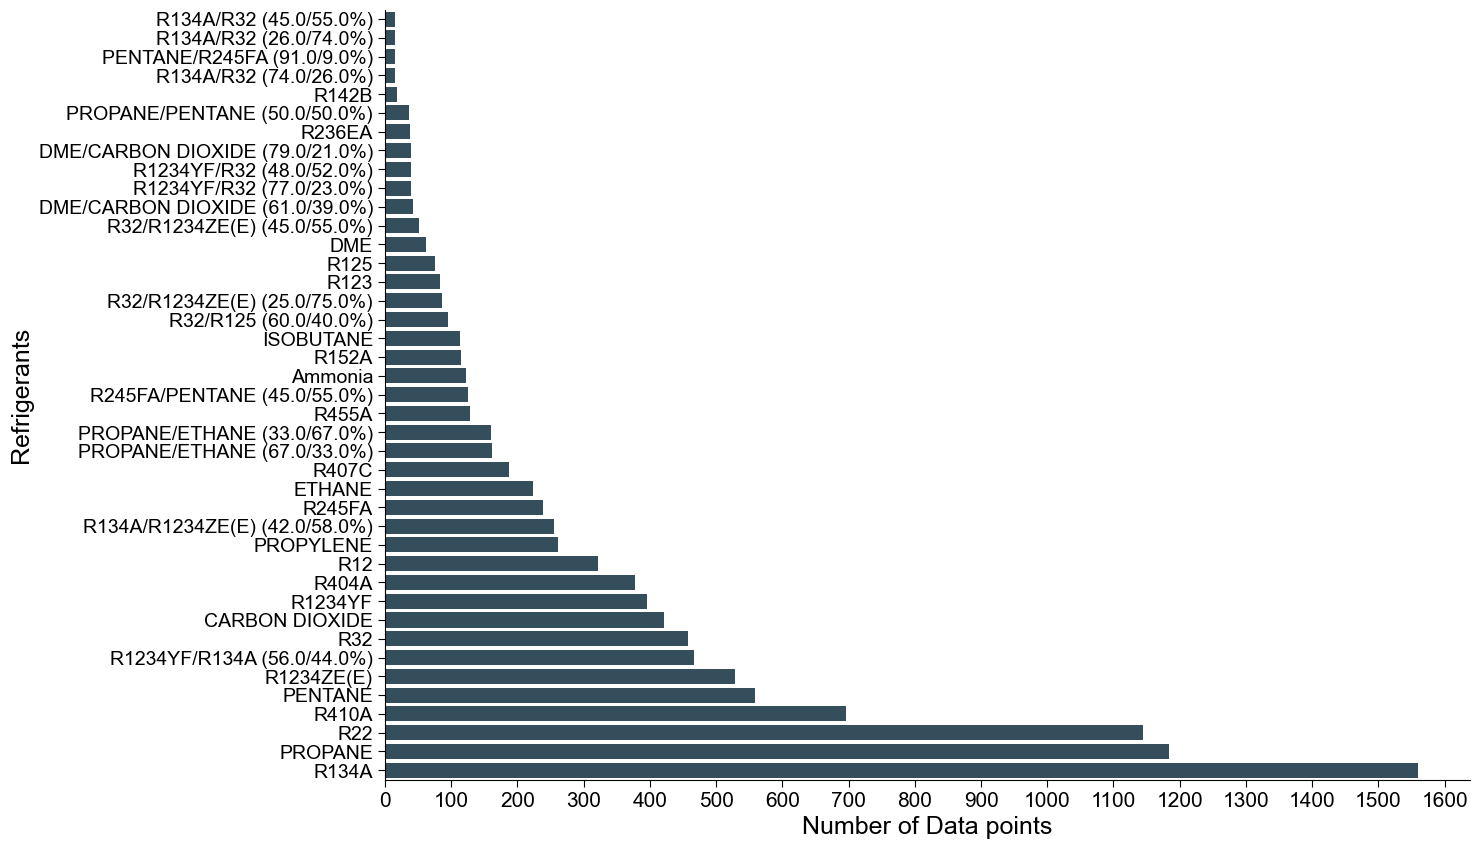

In [21]:
refrigerant_counts = refdata["Refrigerant"].value_counts()
df_counts = refrigerant_counts.reset_index()
df_counts.columns = ['Refrigerant', 'Number of Data Points']

df_counts = df_counts.sort_values(by='Number of Data Points')

fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor("#FFFFFF")  
ax = sns.countplot(y=refdata["Refrigerant"], order=df_counts['Refrigerant'], color="#2f5061")
plt.xticks(range(0, 1700, 100), size=15, fontname='Arial')
plt.yticks(size=14, fontname='Arial')
plt.xlabel('Number of Data points', size=18, fontname='Arial')
plt.ylabel('Refrigerants', size=18, fontname='Arial')
plt.tick_params(axis='y', which='both', length=5)
plt.tick_params(axis='x', which='both', length=5)
ax.set_facecolor("#FFFFFF")
sns.despine()

plt.savefig(r'C:\Users\Other User\Downloads\Refrigerants_countplot.png', bbox_inches='tight', dpi=800)
plt.show()

## Dropping Refrigerants

In [ ]:
refrigerants_to_drop = ['PROPANE/PENTANE (50.0/50.0%)','R142B', 'R134A/R32 (45.0/55.0%)', 'R134A/R32 (26.0/74.0%)', 'PENTANE/R245FA (91.0/9.0%)', 'R134A/R32 (74.0/26.0%)']
refdata = refdata[~refdata['Refrigerant'].isin(refrigerants_to_drop)]
refrigerant_counts = refdata["Refrigerant"].value_counts()
df_counts_filtered = refrigerant_counts.reset_index()
df_counts_filtered.columns = ['Refrigerant', 'Number of Data Points']
print(df_counts_filtered)
df_counts_filtered = df_counts_filtered.sort_values(by='Number of Data Points')
total_data_points = df_counts_filtered['Number of Data Points'].sum()
print(f"\nTotal number of data points: {total_data_points}")
print("After drop:", refdata["Refrigerant"].unique())

                        Refrigerant  Number of Data Points
0                             R134A                   1560
1                           PROPANE                   1184
2                               R22                   1145
3                             R410A                    696
4                           PENTANE                    559
5                        R1234ZE(E)                    528
6        R1234YF/R134A (56.0/44.0%)                    467
7                               R32                    457
8                    CARBON DIOXIDE                    421
9                           R1234YF                    395
10                            R404A                    378
11                              R12                    322
12                        PROPYLENE                    261
13    R134A/R1234ZE(E) (42.0/58.0%)                    256
14                           R245FA                    238
15                           ETHANE                    2

## Distribution Plot

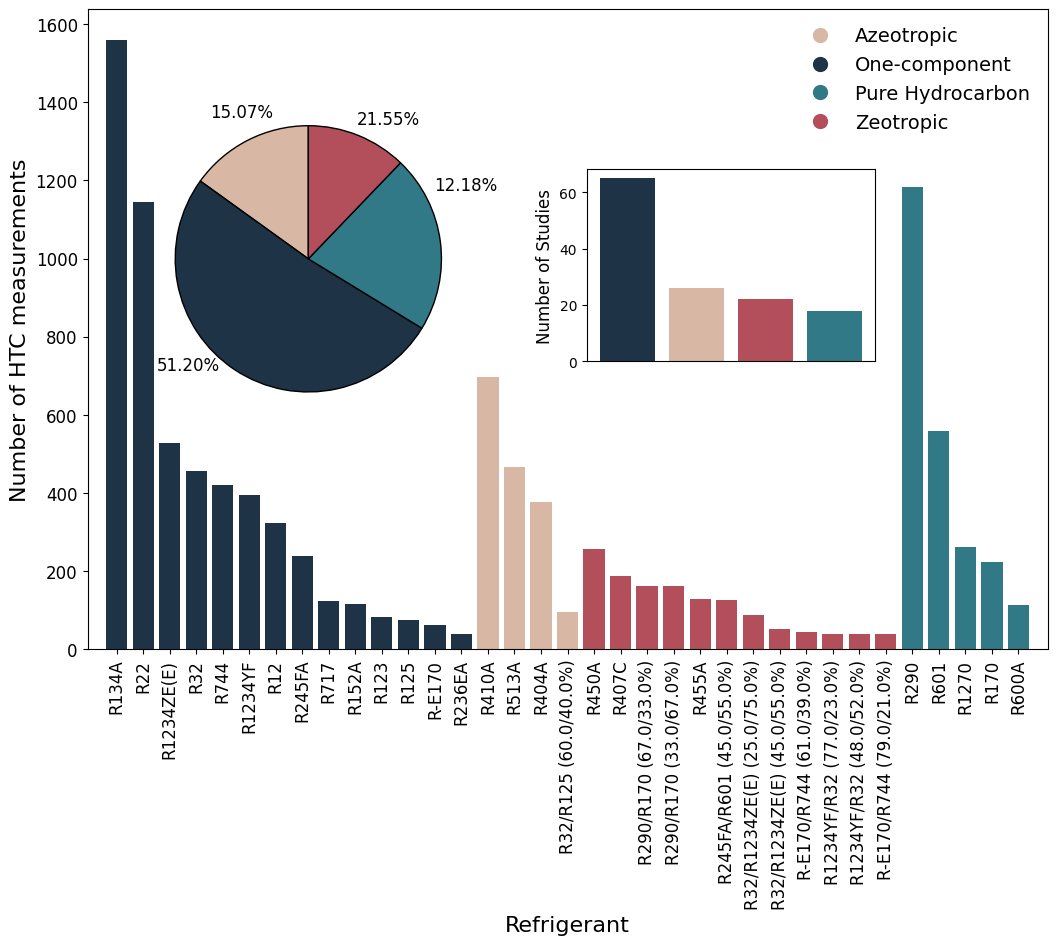

In [ ]:
data = {
    'Refrigerant': [
        'R134A', 'R290', 'R22', 'R410A', 'R601', 'R1234ZE(E)', 
        'R513A', 'R32', 'R744',  'R1234YF', 'R404A', 'R12',
        'R1270', 'R450A', 'R245FA', 'R170', 'R407C',
        'R290/R170 (67.0/33.0%)', 'R290/R170 (33.0/67.0%)',
        'R455A', 'R245FA/R601 (45.0/55.0%)', 'R717', 'R152A', 'R600A',
        'R32/R125 (60.0/40.0%)', 'R32/R1234ZE(E) (25.0/75.0%)', 'R123', 'R125', 'R-E170',
        'R32/R1234ZE(E) (45.0/55.0%)', 'R-E170/R744 (61.0/39.0%)', 'R1234YF/R32 (77.0/23.0%)',
        'R1234YF/R32 (48.0/52.0%)', 'R-E170/R744 (79.0/21.0%)', 'R236EA'
    ],
    'Number of Data Points': [
        1560, 1184, 1145, 696, 559, 528, 467, 457, 421, 395, 378, 322, 261, 256, 238, 
        224, 188, 162, 162, 129, 125, 123, 115, 113, 96, 87, 83, 75, 62, 52, 43, 40, 40, 39, 38
    ]
}

# Category
one_component = [ 'R134A', 'R22', 'R1234ZE(E)', 'R32', 'R744', 'R1234YF', 'R12', 'R245FA', 'R717', 'R152A', 'R123', 'R125', 'R236EA', 'R-E170']
azeotropic = ['R404A', 'R410A', 'R32/R125 (60.0/40.0%)', 'R513A']
zeotropic = ['R407C', 'R455A', 'R450A', 'R245FA/R601 (45.0/55.0%)', 'R32/R1234ZE(E) (25.0/75.0%)', 'R32/R1234ZE(E) (45.0/55.0%)', 'R1234YF/R32 (77.0/23.0%)', 'R1234YF/R32 (48.0/52.0%)', 'R-E170/R744 (61.0/39.0%)', 'R-E170/R744 (79.0/21.0%)', 'R290/R170 (33.0/67.0%)', 'R290/R170 (67.0/33.0%)']
pure_hydrocarbons = ['R290', 'R1270', 'R600A', 'R601', 'R170']

df = pd.DataFrame(data)
df['Category'] = df['Refrigerant'].apply(lambda x: 'One-component' if x in one_component else (
    'Azeotropic' if x in azeotropic else (
        'Zeotropic' if x in zeotropic else 'Pure Hydrocarbon')))

df = df.sort_values(by='Number of Data Points', ascending=False)
category_data_counts = df.groupby('Category')['Number of Data Points'].sum()
category_colors = {
    'One-component': '#1e3446',  
    'Azeotropic': '#d8b8a5',  
    'Zeotropic': '#b34f5b',  
    'Pure Hydrocarbon': '#327987'
}

# bar plot
plt.figure(figsize=(12, 8))
for category, color in category_colors.items():
    category_data = df[df['Category'] == category]
    plt.bar(category_data['Refrigerant'], category_data['Number of Data Points'], 
            color=color, alpha=1)

plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Refrigerant', fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('Number of HTC measurements', fontsize=16)

# pie chart
ax_pie = plt.gca().inset_axes([-0.03, 0.35, 0.52, 0.52]) 
labels = category_data_counts.index
sizes = category_data_counts.values  
colors = [category_colors[label] for label in labels]

wedges, texts, autotexts = ax_pie.pie(
    sizes, autopct='', colors=colors, startangle=90,
    textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    pctdistance=0.1,  
    labeldistance=1.1  
)

manual_offsets = {
    'One-component': (-0.9, -0.8),  
    'Azeotropic': (-0.5, 1.1),  
    'Zeotropic': (1.18, 0.55),  
    'Pure Hydrocarbon': (0.6, 1.05)  
}

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    category = labels[i]
    
    x_label, y_label = manual_offsets[category]
    
    percentage = f'{(sizes[i] / sizes.sum()) * 100:.2f}%'
    ax_pie.text(x_label, y_label, percentage, ha='center', va='center', fontsize=12, color='black')

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12) for color in colors]
plt.legend(custom_lines, labels, loc='upper right', fontsize=14, frameon=False)

study_counts = {
    'One-component': 65,
    'Azeotropic': 26,
    'Zeotropic': 22,
    'Pure Hydrocarbon':18 ,
}

categories = list(study_counts.keys())
studies = list(study_counts.values())
x_pos = np.arange(len(categories))
ax2 = plt.gca().inset_axes([0.52, 0.45, 0.3, 0.3])  
ax2.bar(x_pos, studies, color=[category_colors[cat] for cat in categories])
ax2.set_xticks([])
ax2.set_ylabel('Number of Studies', fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.margins(x=0.02)  
plt.savefig(r'C:\Users\Other User\Downloads\dataset.png', bbox_inches='tight', dpi=800)
plt.savefig(r'C:\Users\Other User\Downloads\dataset.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [24]:
refdata.head()

,Refrigerant 1,Refrigerant 2,m1,G (kg/m2s),x,DT (0C),h (W/m2K),m2,Tsat (K),rho_l,...,mu_v,k_v,k_l,surface_tension,Cp_v,Cp_l,Z,Psat (Pa),D (m),Refrigerant
0,R134A,0,0.0,74.0,0.33,3.36,2475.0,0.0,309.25,1163.007871,...,0.000012,0.014997,0.076383,0.006603,1111.584096,1476.647359,0.0,914363.250653,0.00314,R134A
1,R134A,0,0.0,53.0,0.42,4.15,2279.0,0.0,309.05,1163.828136,...,0.000012,0.014974,0.076469,0.006629,1109.974844,1475.587638,0.0,909337.850388,0.00314,R134A
2,R134A,0,0.0,70.0,0.46,4.97,2430.0,0.0,310.85,1156.397513,...,0.000012,0.015178,0.075699,0.006402,1124.725741,1485.316107,0.0,955321.020171,0.00314,R134A
3,R134A,0,0.0,75.0,0.48,2.78,2849.0,0.0,308.45,1166.281061,...,0.000012,0.014907,0.076725,0.006704,1105.190064,1472.439232,0.0,894386.055501,0.00314,R134A
4,R134A,0,0.0,76.0,0.57,2.83,2925.0,0.0,308.65,1165.464724,...,0.000012,0.014930,0.076640,0.006679,1106.777894,1473.483618,0.0,899349.309041,0.00314,R134A


## HeatMap

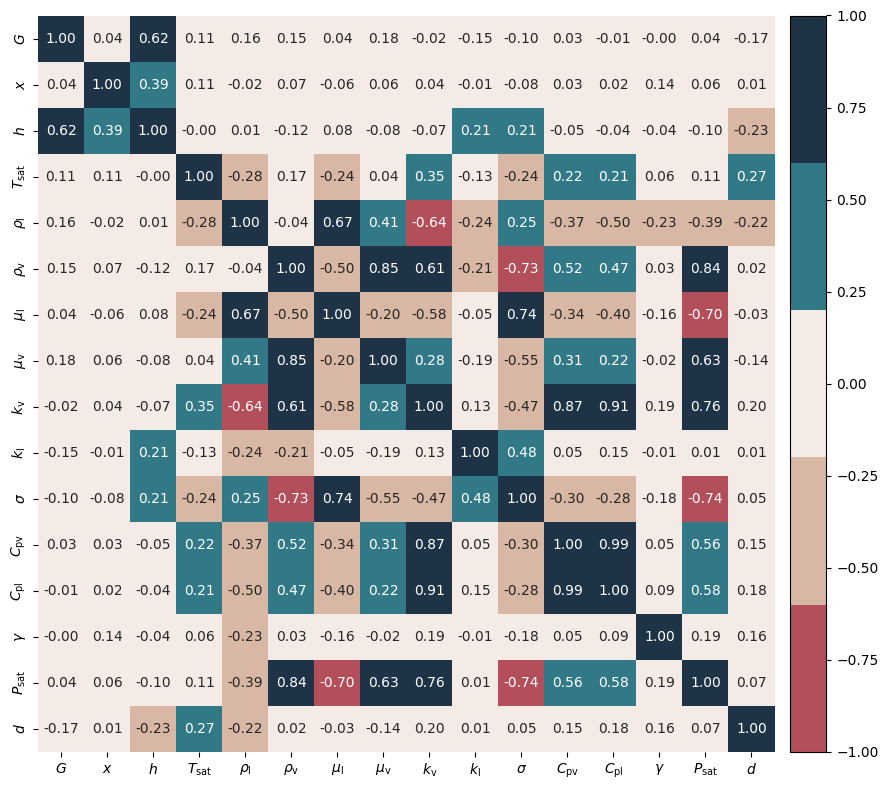

In [ ]:
refdata = refdata.drop(['Refrigerant 1', 'Refrigerant 2','Refrigerant', 'm1', 'm2', 'DT (0C)'], axis=1)
colors = [
    '#b34f5b',  
    '#d8b8a5',  
    '#f4eae6',  
    '#327987',  
    '#1e3446'   
]
cmap = ListedColormap(colors)

var_labels = [
    r"$G$", 
    r"$x$", 
    r"$h$", 
    r"$T_\mathrm{sat}$", 
    r"$\rho_\mathrm{l}$", 
    r"$\rho_\mathrm{v}$", 
    r"$\mu_\mathrm{l}$", 
    r"$\mu_\mathrm{v}$", 
    r"$k_\mathrm{v}$", 
    r"$k_\mathrm{l}$", 
    r"$\sigma$", 
    r"$C_\mathrm{pv}$", 
    r"$C_\mathrm{pl}$", 
    r"$\gamma$",
    r"$P_\mathrm{sat}$", 
    r"$d$" 
]

corr_matrix = refdata.corr()
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)

# heatmap
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt='.2f', square=True,
                xticklabels=var_labels,
                yticklabels=var_labels,
                cbar=False, ax=ax, vmin = -1, vmax = 1)

cax = divider.append_axes("right", size="5%", pad=0.15)  
cbar = fig.colorbar(ax.collections[0], cax=cax)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')
plt.tight_layout()
fig.savefig(r'C:\Users\Other User\Downloads\heatmap_beforelog.pdf', bbox_inches='tight', dpi=800)
plt.show()

In [26]:
numeric_cols = refdata.select_dtypes(include=[np.number]).columns.tolist()
non_positive_vars = {}
for col in numeric_cols:
    non_positive_count = (refdata[col] <= 0).sum()  # Count non-positive values
    if non_positive_count > 0:
        non_positive_vars[col] = non_positive_count

if non_positive_vars:
    print("Columns with non-positive values:")
    for col, count in non_positive_vars.items():
        print(f"{col}: {count} non-positive values")
else:
    print("No non-positive values found in numeric columns.")

Columns with non-positive values:
Z: 7903 non-positive values


In [27]:
refdata.shape[0]

10861

## Density Plot

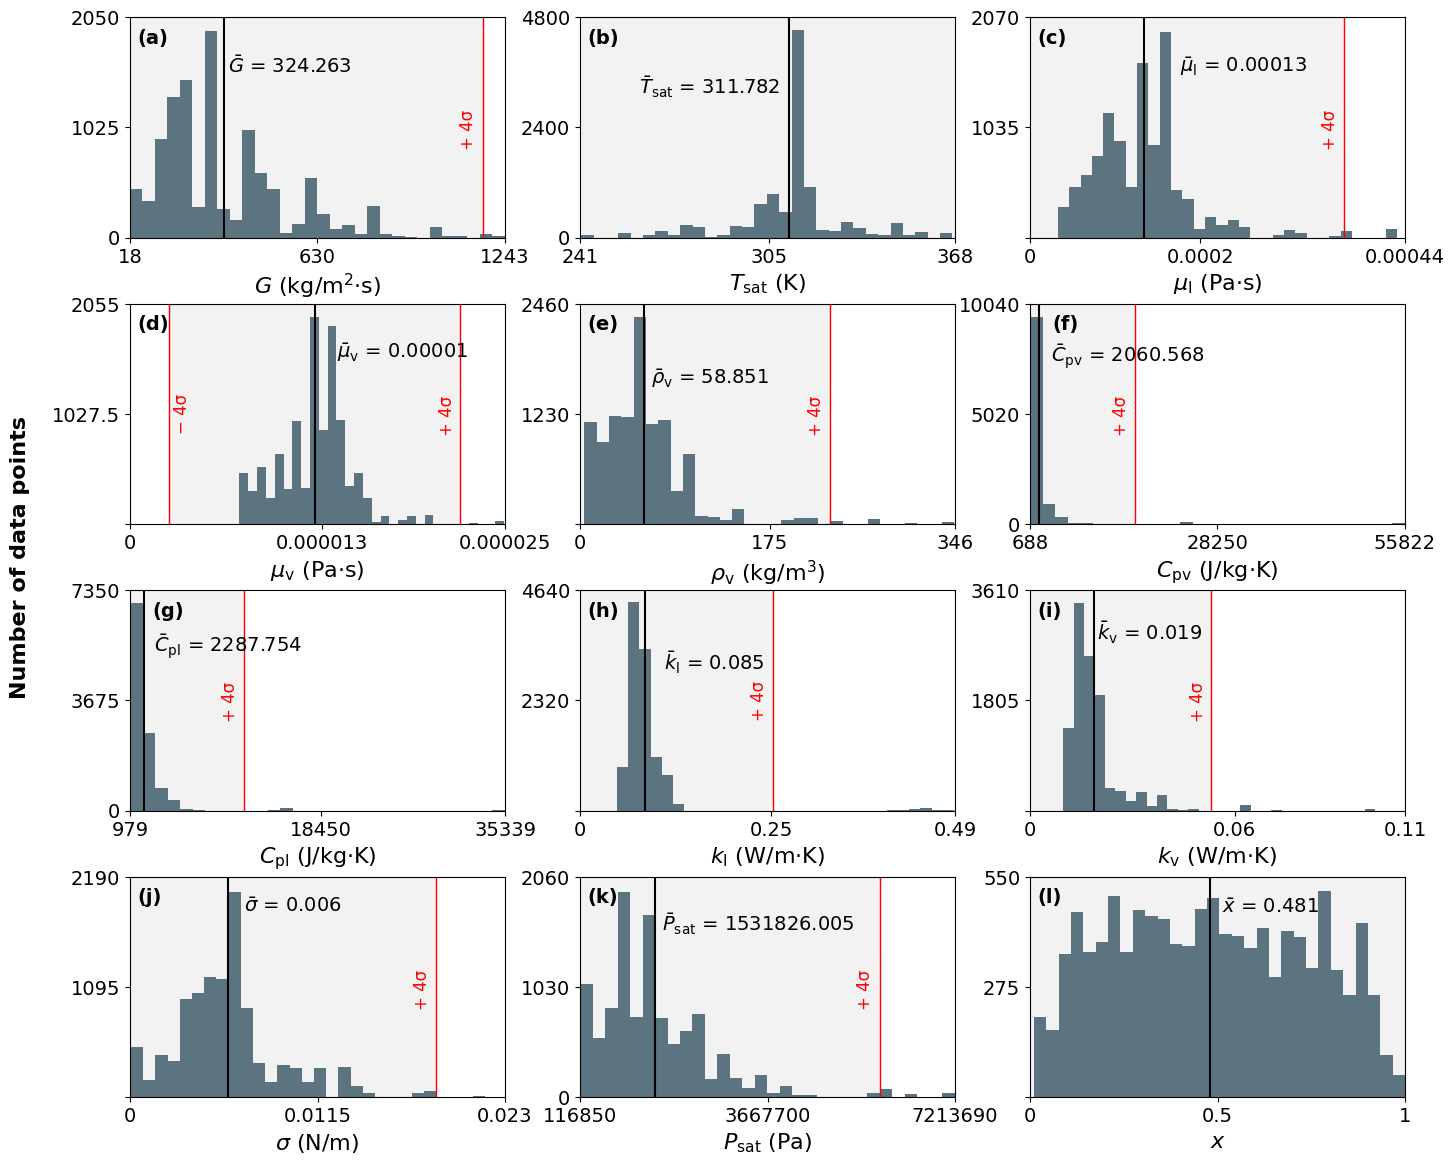

In [ ]:
manual_ticks = {
    "G (kg/m2s)": {
        "x": [18, 630, 1243],
        "y": [0, 1025, 2050]
    },
    "x": {
        "x": [0, 0.5, 1],
        "y": [0, 275, 550]
    },
    "Tsat (K)": {
        "x": [241, 305, 368],
        "y": [0, 2400, 4800]
    },
    "rho_v": {
        "x": [0, 175, 346],
        "y": [0, 1230, 2460]
    },
    "Cp_v": {
        "x": [688, 28250, 55822],
        "y": [0, 5020, 10040]
    },
    "Cp_l": {
        "x": [979, 18450, 35339],
        "y": [0, 3675, 7350]
    },
    "Psat (Pa)": {
        "x": [116850, 3667700, 7213690],
        "y": [0, 1030, 2060]
    },
    "mu_l": {
        "x": [0, 0.0002, 0.00044],
        "y": [0, 1035, 2070]
    },
    "mu_v": {
        "x": [0, 1.26e-5, 2.46e-5],
        "y": [0, 1027.5, 2055]
    },
    "k_l": {
        "x": [0, 0.25, 0.49],
        "y": [0, 2320, 4640]
    },
    "k_v": {
        "x": [0, 0.06, 0.11],
        "y": [0, 1805, 3610]
    },
    "surface_tension": {
        "x": [0, 0.0115, 0.023],
        "y": [0, 1095, 2190]
    }
}

sigma_annotation_coords = {
    "G (kg/m2s)": {
        "-4": (100, 1500),
        "+4": (800, 1500)
    },
    "x": {
        "-4": (0.05, 400),
        "+4": (0.95, 400)
    },
    "rho_v": {
        "-4": (20, 1800),
        "+4": (330, 1800)
    },
    "Cp_v": {
        "-4": (2000, 7000),
        "+4": (55000, 7000)
    },
    "Cp_l": {
        "-4": (1500, 5000),
        "+4": (35000, 5000)
    },
    "Psat (Pa)": {
        "-4": (200000, 1500),
        "+4": (7000000, 1500)
    },
    "mu_l": {
        "-4": (0.00005, 1500),
        "+4": (0.0004, 1500)
    },
    "mu_v": {
        "-4": (2.58898190010152e-06, 1027.5),
        "+4": (2.4e-5, 1500)
    },
    "k_l": {
        "-4": (0.05, 3000),
        "+4": (0.48, 3000)
    },
    "k_v": {
        "-4": (0.01, 2500),
        "+4": (0.10, 2500)
    },
    "surface_tension": {
        "-4": (0.005, 1500),
        "+4": (0.021, 1500)
    }
}

def format_ticks(ticks, decimals=6):
    labels = []
    for x in ticks:
        s = f"{x:.{decimals}f}".rstrip('0').rstrip('.')
        labels.append(s)
    return labels

# Mean symbols 
mean_symbols = {
    "G (kg/m2s)": r"$\bar{G}$",
    "x": r"$\bar{x}$",
    "Tsat (K)": r"$\bar{T}_\mathrm{sat}$",
    "rho_l": r"$\bar{\rho}_\mathrm{l}$",
    "rho_v": r"$\bar{\rho}_\mathrm{v}$",
    "mu_l": r"$\bar{\mu}_\mathrm{l}$",
    "mu_v": r"$\bar{\mu}_\mathrm{v}$",
    "k_v": r"$\bar{k}_\mathrm{v}$",
    "k_l": r"$\bar{k}_\mathrm{l}$",
    "surface_tension": r"$\bar{\sigma}$",
    "Cp_v": r"$\bar{C}_\mathrm{pv}$",
    "Cp_l": r"$\bar{C}_\mathrm{pl}$",
    "Psat (Pa)": r"$\bar{P}_\mathrm{sat}$",
}

mean_annotation_coords = {
    "G (kg/m2s)": (540,1500 ),
    "x": (0.64,450),
    "Tsat (K)": (285,3000),
    "rho_v": (120,1500),
    "Cp_v": (15000,7000),
    "Cp_l": (10000,5000),
    "Psat (Pa)": (3500000,1500),
    "mu_l": (0.00025,1500),
    "mu_v": (0.0000179,1500),
    "k_l": (0.175,2850),
    "k_v": (0.035,2700),
    "surface_tension": (0.01,1800)
}

def plot_counts_with_sigma(ax, data, column, xlabel):
    mean = data[column].mean()
    std = data[column].std()

    ax.hist(data[column], bins=30, color='#2f5061', alpha=0.8)

    neg_4sigma = mean - 4 * std
    pos_4sigma = mean + 4 * std
    data_min = data[column].min()
    data_max = data[column].max()

    ax.axvspan(neg_4sigma, pos_4sigma, color='gray', alpha=0.1)
    ax.axvline(mean, linestyle='-', color='black', linewidth=1.5)

    mean_symbol = mean_symbols.get(column, r"$\bar{x}$")

    if column in ['mu_l', 'mu_v']:
        mean_str = f"{mean:.5f}"
    else:
        mean_str = f"{mean:.3f}"

    mean_label = f"{mean_symbol} = {mean_str}"

    x_text, y_text = mean_annotation_coords.get(column, (None, None))
    ylim = ax.get_ylim()
    if x_text is None:
        x_text = mean
    if y_text is None:
        y_text = 0.9 * ylim[1]

    ax.text(x_text, y_text, mean_label, color='black', fontsize=14,
            va='bottom', ha='center')

    sigmas_to_show = []
    if neg_4sigma >= 0 and column != "Tsat (K)":
        sigmas_to_show.append((-4, "− 4σ"))
    if data_max >= pos_4sigma:
        sigmas_to_show.append((4, "+ 4σ"))

    for n, label in sigmas_to_show:
        level = mean + n * std
        ax.axvline(level, linestyle='-', color='red', linewidth=1)

        coords = sigma_annotation_coords.get(column, {}).get(str(n), None)
        if coords is None:
            y_mid = 0.5 * ax.get_ylim()[1]
            x_text = level
            y_text = y_mid
        else:
            x_text, y_text = coords

        x_min, x_max = ax.get_xlim()
        pad = 0.01 * (x_max - x_min) 

        if n < 0:
            x_text += pad  
            ha = 'left'
        else:
            x_text -= pad  
            ha = 'right'

        ax.text(x_text, y_text, label, color='red', fontsize=12,
                rotation=90, va='center', ha=ha)

    xticks = manual_ticks[column]["x"]
    yticks = manual_ticks[column]["y"]

    ax.set_xticks(xticks)
    ax.set_xticklabels(format_ticks(xticks), fontsize=14)
    ax.set_xlim(xticks[0], xticks[-1])

    ax.set_yticks(yticks)
    ax.set_yticklabels(format_ticks(yticks), fontsize=14)

    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel("")

symbol_labels = {
    "G (kg/m2s)": r"$G$ (kg/m$^2$·s)",
    "x": r"$x$",
    "Tsat (K)": r"$T_\mathrm{sat}$ (K)",
    "rho_v": r"$\rho_\mathrm{v}$ (kg/m$^3$)",
    "mu_l": r"$\mu_\mathrm{l}$ (Pa·s)",
    "mu_v": r"$\mu_\mathrm{v}$ (Pa·s)",
    "k_v": r"$k_\mathrm{v}$ (W/m·K)",
    "k_l": r"$k_\mathrm{l}$ (W/m·K)",
    "surface_tension": r"$\sigma$ (N/m)",
    "Cp_v": r"$C_\mathrm{pv}$ (J/kg·K)",
    "Cp_l": r"$C_\mathrm{pl}$ (J/kg·K)",
    "Psat (Pa)": r"$P_\mathrm{sat}$ (Pa)"
}

columns = [
    ("G (kg/m2s)", symbol_labels["G (kg/m2s)"]),
    ("Tsat (K)", symbol_labels["Tsat (K)"]),
    ("mu_l", symbol_labels["mu_l"]),
    ("mu_v", symbol_labels["mu_v"]),
    ("rho_v", symbol_labels["rho_v"]),
    ("Cp_v", symbol_labels["Cp_v"]),
    ("Cp_l", symbol_labels["Cp_l"]),
    ("k_l", symbol_labels["k_l"]),
    ("k_v", symbol_labels["k_v"]),
    ("surface_tension", symbol_labels["surface_tension"]),
    ("Psat (Pa)", symbol_labels["Psat (Pa)"]),
    ("x", symbol_labels["x"])
]

# Subplot 
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)',
                  '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']

special_subplots = ['(c)', '(d)', '(e)', '(h)', '(i)', '(j)', '(l)']
ncols = 3
nrows = int(np.ceil(len(columns) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()

for i, (column, xlabel) in enumerate(columns):
    plot_counts_with_sigma(axes[i], refdata, column, xlabel)

    x_pos = 0.02
    if subplot_labels[i] in ['(f)', '(g)']:
        x_pos = 0.06 

    axes[i].text(x_pos, 0.95, subplot_labels[i],
                 transform=axes[i].transAxes,
                 fontsize=14, fontweight='bold', va='top', ha='left')
    if subplot_labels[i] in special_subplots:
        yticklabels = axes[i].get_yticklabels()
        for label in yticklabels:
            if label.get_text() == '0':
                label.set_visible(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.04, 0.5, 'Number of data points', va='center', rotation='vertical',
         fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.3, wspace=0.2, left=0.12, right=0.97, top=0.95, bottom=0.05)
fig.savefig(r'C:\Users\Other User\Downloads\density.pdf',
            bbox_inches='tight', dpi=800)

plt.show()

## Outlier Removal

In [ ]:
def drop_outliers_4sigma_with_counts(data, columns):
    removed_counts = {}
    for column in columns:
        mean = data[column].mean()
        std = data[column].std()
        condition = (data[column] >= mean - 4 * std) & (data[column] <= mean + 4 * std)
        removed = (~condition).sum()
        removed_counts[column] = removed
        data = data[condition]
    return data, removed_counts

columns_to_consider = [
    "G (kg/m2s)", "Tsat (K)", "mu_l", "mu_v", "rho_l", "rho_v",
    "k_l", "k_v", "surface_tension", "Psat (Pa)", "x", "D (m)", "Cp_l", "Cp_v"
]

print("Original shape:", refdata.shape)

refdata_filtered, removed_counts = drop_outliers_4sigma_with_counts(refdata.copy(), columns_to_consider)

print("Filtered shape:", refdata_filtered.shape)
print("Removed counts per feature:")
for col, count in removed_counts.items():
    print(f"{col}: {count}")
for column in refdata_filtered.columns:
    min_value = refdata_filtered[column].min()
    max_value = refdata_filtered[column].max()
    print(f"{column}: Min = {min_value}, Max = {max_value}")

Original shape: (10861, 16)
Filtered shape: (10039, 16)
Removed counts per feature:
G (kg/m2s): 44
Tsat (K): 14
mu_l: 147
mu_v: 39
rho_l: 0
rho_v: 84
k_l: 123
k_v: 92
surface_tension: 0
Psat (Pa): 113
x: 0
D (m): 0
Cp_l: 46
Cp_v: 120
G (kg/m2s): Min = 24.0, Max = 1100.0
x: Min = 0.01, Max = 1.0
h (W/m2K): Min = 85.29, Max = 23884.91
Tsat (K): Min = 242.06690717133566, Max = 356.15
rho_l: Min = 362.185863423605, Max = 1424.780214166073
rho_v: Min = 3.9225140453547667, Max = 207.9564224473577
mu_l: Min = 4.623656086890391e-05, Max = 0.0003523979279965947
mu_v: Min = 7.181225595234268e-06, Max = 1.6946543610052165e-05
k_v: Min = 0.01008878234480776, Max = 0.03737606033932814
k_l: Min = 0.04877014331596767, Max = 0.13144615213383912
surface_tension: Min = 0.0006135893062364861, Max = 0.013430542381338211
Cp_v: Min = 688.984067329722, Max = 4958.936829511559
Cp_l: Min = 979.4469287879308, Max = 4745.107485554483
Z: Min = 0.0, Max = 0.1524419577247821
Psat (Pa): Min = 116851.05484944436, Max

In [30]:
lowest_20 = refdata_filtered.sort_values(by='h (W/m2K)').head(20)
highest_20 = refdata_filtered.sort_values(by='h (W/m2K)', ascending=False).head(20)
print("Lowest 20 values of h (W/m2K):")
print(lowest_20[['h (W/m2K)']])
print("\nHighest 20 values of h (W/m2K):")
print(highest_20[['h (W/m2K)']])

Lowest 20 values of h (W/m2K):
      h (W/m2K)
9571      85.29
9568     170.04
9557     181.97
5187     287.70
1021     302.75
9561     325.23
4789     334.00
4878     336.00
1022     348.29
9470     352.27
5186     367.06
5226     406.43
1023     406.60
9464     423.54
5206     436.51
5185     436.51
8688     436.89
1024     474.27
5184     476.19
5196     486.11

Highest 20 values of h (W/m2K):
      h (W/m2K)
4651   23884.91
7064   22163.59
4635   21903.68
4662   21652.26
6991   21506.94
6798   20998.20
6563   20465.04
7063   20184.70
6980   20026.67
6335   19930.17
6990   19897.38
7053   18931.40
4655   18921.70
6434   18894.93
6726   18859.51
6562   18786.65
7062   18733.51
6989   18690.34
6979   18551.52
4650   18436.57


## Manual Cleaning

In [ ]:
sorted_data = refdata_filtered.sort_values(by='h (W/m2K)')
data_dropped = sorted_data.iloc[5:-5].copy()
for column in data_dropped.columns:
    min_value = data_dropped[column].min()
    max_value = data_dropped[column].max()
    mean_value = data_dropped[column].mean()
    median_value = data_dropped[column].median()
    print(f"{column}: Min = {min_value}, Max = {max_value}, Mean = {mean_value}, Median = {median_value}")
refdata_filtered = data_dropped.copy()

In [32]:
refdata_filtered.shape[0]

10029

## Shah Regime

Missing P_cr values: 0


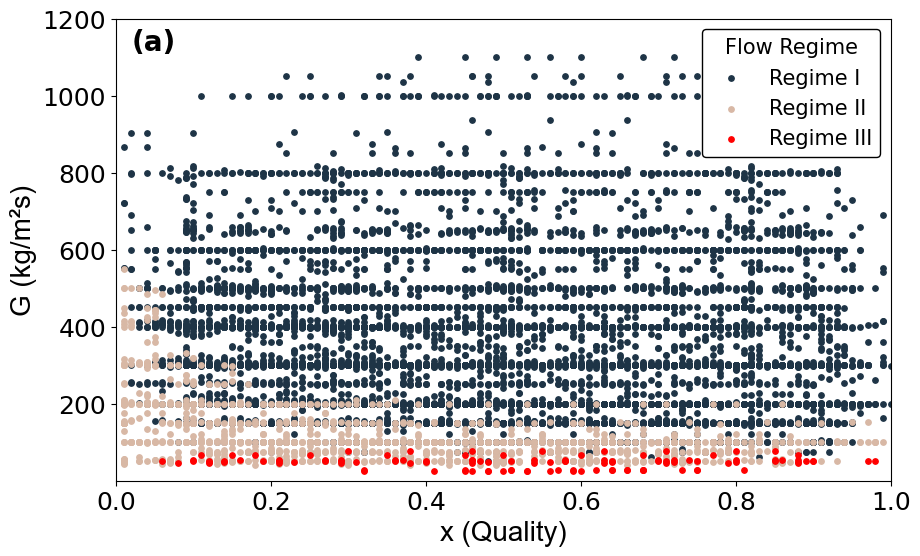

CSV file saved successfully at C:\Users\Other User\Downloads\x_vs_G_flow_regimes_.csv


In [ ]:
dataset = refdata_filtered.copy()

P_cr = {
    'R12': 4.136e6,
    'R14': 3.75e6,
    'R123': 3.66e6,
    'R125': 3.592e6,
    'R22': 4.99e6,
    'R32': 5.78e6,
    'R134A': 4.059e6,
    'R152A': 4.52e6,
    'R142B': 4.14e6,
    'R236EA': 3.52e6,
    'R245FA': 3.65e6,
    'R1234YF': 3.382e6,
    'R1234ZE(E)': 3.635e6,
    'DME': 5.24e6,
    'Ammonia': 11.33e6,
    'CARBON DIOXIDE': 7.38e6,
    'R404A': 3.7315e6,
    'R410A': 4.95e6,
    'R32/R125 (50.0/50.0%)': 4.90e6,
    'R32/R125 (60.0/40.0%)': 5.10e6,
    'R1234YF/R134A (56.0/44.0%)': 3.50e6,
    'R407C': 4.6191e6,
    'R455A': 4.92e6,
    'R1234YF/R32 (48.0/52.0%)': 4.80e6,
    'R1234YF/R32 (77.0/23.0%)': 4.20e6,
    'R134A/R1234ZE(E) (42.0/58.0%)': 3.80e6,
    'R32/R1234ZE(E) (25.0/75.0%)': 4.60e6,
    'R32/R1234ZE(E) (45.0/55.0%)': 4.80e6,
    'R134A/R32 (45.0/55.0%)': 4.90e6,
    'R134A/R32 (26.0/74.0%)': 5.00e6,
    'R134A/R32 (74.0/26.0%)': 4.80e6,
    'R245FA/PENTANE (45.0/55.0%)': 2.90e6,
    'PENTANE/R245FA (91.0/9.0%)': 2.80e6,
    'DME/CARBON DIOXIDE (61.0/39.0%)': 6.00e6,
    'DME/CARBON DIOXIDE (79.0/21.0%)': 5.80e6,
    'PROPANE/ETHANE (33.0/67.0%)': 4.50e6,
    'PROPANE/ETHANE (67.0/33.0%)': 4.80e6,
    'PROPANE/PENTANE (50.0/50.0%)': 3.80e6,
    'PROPANE': 4.25e6,
    'PROPYLENE': 4.66e6,
    'ISOBUTANE': 3.64e6,
    'PENTANE': 3.37e6,
    'METHANE': 4.60e6,
    'ETHANE': 4.88e6
}

dataset = dataset.merge(refregime[['Refrigerant']], left_index=True, right_index=True)
dataset["P_cr (Pa)"] = dataset["Refrigerant"].apply(lambda ref: P_cr.get(ref, None))
missing_pcr = dataset["P_cr (Pa)"].isna().sum()
print(f"Missing P_cr values: {missing_pcr}")
g = 9.81
def calculate_we_fr(row):
    G = row['G (kg/m2s)']
    x = row['x']
    rho_l = row['rho_l']
    rho_v = row['rho_v']
    mu_l = row['mu_l']
    mu_v = row['mu_v']
    surface_tension = row['surface_tension']
    D = row['D (m)']
    P_cr = row['P_cr (Pa)']
    Psat = row['Psat (Pa)']

    if P_cr is None or Psat is None:
        return pd.Series({'J_g': np.nan, 'Z': np.nan})

    pr = Psat / P_cr
    We = (G**2 * D) / (rho_v * surface_tension)
    J_g = (x * G) / ((g * D * rho_v * (rho_l - rho_v)) ** 0.5)
    Z = (((1 / x) - 1) ** 0.8) * (pr ** 0.4)

    return pd.Series({'G': G, 'x':x,'J_g': J_g, 'Z': Z, 'We' : We, 'D': D})

dataset[['G', 'x', 'J_g', 'Z', 'We', 'D']] = dataset.apply(calculate_we_fr, axis=1)
def identify_flow_regime(row):
    J_g = row['J_g']
    Z = row['Z']
    D = row['D']
    We = row['We']
    G = row['G']
    x = row['x']
    if D > 0.003:
        if J_g >= 0.98 * (Z + 0.263) ** -0.62:
            return "Regime I"
        elif J_g <= 0.95 * (1.254 + 2.72 * Z ** 1.249) ** -1:
            return "Regime III"
        else:
            return "Regime II"
    else:
        if We > 100 and J_g >= 0.98 * (Z + 0.263) ** -0.62:
            return "Regime I"
        elif We > 20 and J_g <= 0.95 * (1.254 + 2.72 * Z ** 1.249) ** -1:
            return "Regime III"
        else:
            return "Regime II"

dataset["Flow_Regime"] = dataset.apply(identify_flow_regime, axis=1)
colors = {
    "Regime I": "#1e3446",  
    "Regime II": "#d8b8a5", 
    "Regime III": "red",  
}

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0, 1)  
ax.set_ylim(0, dataset["G"].max() + 100) 
ax.text(0.02, 0.98, '(a)', fontsize=20, fontweight='bold', transform=ax.transAxes, va='top', ha='left')

for regime, color in colors.items():
    regime_data = dataset[dataset["Flow_Regime"] == regime]
    ax.scatter(regime_data["x"], regime_data["G"], label=regime, color=color, s=15, alpha=1)

plt.xlabel("x (Quality)", fontsize=20, fontname='Arial')
plt.ylabel("G (kg/m²s)", fontsize=20, fontname='Arial')
legend = plt.legend(title="Flow Regime", fontsize=15, title_fontsize=15, loc='upper right',
                     frameon=True, facecolor='white', framealpha=1, edgecolor='black')

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

current_yticks = ax.get_yticks()
new_yticks = [tick for tick in current_yticks if tick != 0]
ax.set_yticks(new_yticks)

current_xticks = ax.get_xticks()
if 0 not in current_xticks:
    current_xticks = np.insert(current_xticks, 0, 0)
ax.set_xticks(current_xticks)

plt.show()
output_path = r'C:\Users\Other User\Downloads\x_vs_G_flow_regimes_.csv'
dataset.to_csv(output_path, index=False)

print(f"CSV file saved successfully at {output_path}")
fig.savefig(r'C:\Users\Other User\Downloads\regime_shah.png', bbox_inches='tight', dpi=800)
fig.savefig(r'C:\Users\Other User\Downloads\regime_shah.pdf', bbox_inches='tight', dpi=600)
        

## Hajal Regime

C:\Users\Other User\AppData\Local\Temp\ipykernel_19300\1689443712.py:36: RuntimeWarning: invalid value encountered in scalar divide
  e = (e_h - e_ra) / np.log(e_h/e_ra)
C:\Users\Other User\AppData\Local\Temp\ipykernel_19300\1689443712.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_strat_solution = fsolve(equation, np.pi)[0]
C:\Users\Other User\AppData\Local\Temp\ipykernel_19300\1689443712.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  50 - 75 * np.exp((x**2 - 0.97)**2 / (x * (x-1)))


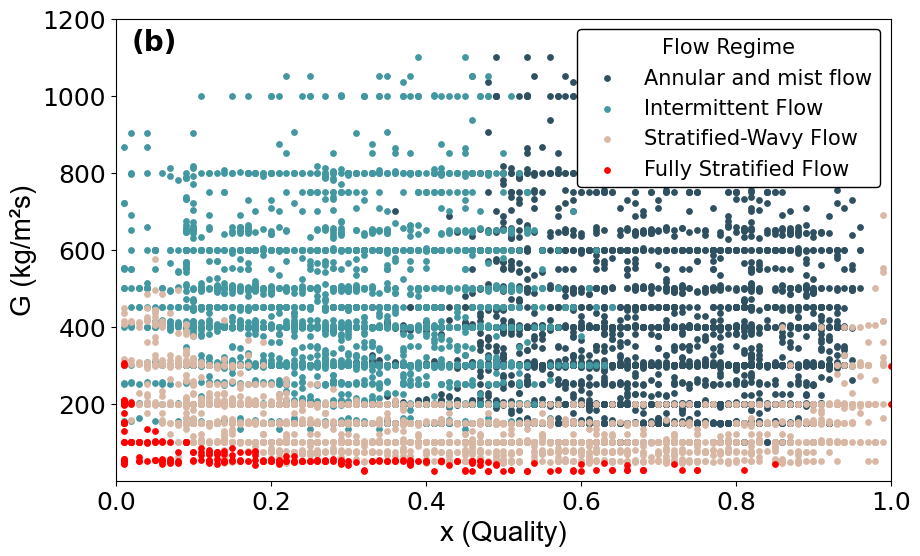

CSV file saved successfully at C:\Users\Other User\Downloads\x_vs_G_flow_regimes.csv


In [ ]:
dataset_copy = refdata_filtered.copy()
g = 9.81

def solve_theta_strat(A_ld):
    """
    Solve for theta_strat given A_ld.
    """
    def equation(theta):
        return A_ld - 0.125 * ((2 * np.pi - theta) - np.sin(2 * np.pi - theta))
    
    theta_strat_solution = fsolve(equation, np.pi)[0]
    return theta_strat_solution

def calculate_we_fr(row):
    """
    Calculate Weber and Froude numbers for each row.
    """
    G = row['G (kg/m2s)']
    x = row['x']
    rho_l = row['rho_l']
    rho_v = row['rho_v']
    mu_l = row['mu_l']
    mu_v = row['mu_v']
    surface_tension = row['surface_tension']
    D = row['D (m)']

    # dimensionless numbers
    A = (math.pi * D**2)/4
    e_h = 1 / (1 + ((1 - x) / x) * (rho_v / rho_l))
    e_ra = (x / rho_v) * ((1 + 0.12 * (1 - x)) * (x / rho_v + (1 - x) / rho_l)\
                          + 1.18 * (1 - x) * ((g * surface_tension * (rho_l - rho_v)) ** 0.25) / (G * (rho_l ** 0.5)))**(-1)
    e = (e_h - e_ra) / np.log(e_h/e_ra)
    A_l = A* (1-e)
    A_v = A*e
    A_ld = A_l/D**2
    A_vd = A_v/D**2
    theta_strat = solve_theta_strat(A_ld)
    h_Ld = 0.5 * (1 - np.cos((2 * np.pi - theta_strat) / 2))
    P_id = np.sin((2 * np.pi - theta_strat) / 2)
    h_L = h_Ld * D
    P_i = P_id * D
    F1 = 0
    F2 = 1.023
    We_Fr = g * D**2 * rho_l / surface_tension
    zeta = (1.138 + 2 * np.log(math.pi/(1.5*A_ld)))**-2
    X_IA = (0.2914 * (rho_v / rho_l)**(-1/1.75) * (mu_l / mu_v)**(-1/7) + 1)**(-1)
    G_wavy = (((16 * A_vd**3 * g * D * rho_l * rho_v) / (x**2 * np.pi**2 * np.sqrt(1 - (2 * h_Ld - 1)**2)))\
              * (np.pi**2 / (25 * h_Ld**2) * (We_Fr)**(-1.023) + 1))**0.5 + \
             50 - 75 * np.exp((x**2 - 0.97)**2 / (x * (x-1)))
    G_strat = ((226.3 **2 * A_ld * A_vd**2 * rho_v * (rho_l - rho_v) * mu_l * g) / (x**2 * (1-x) * (math.pi)**3))**(1/3) + 20 * x
    G_mist = (((7680 * A_vd**2 * g * D * rho_v * rho_l) / (x**2 * (math.pi)**2 * zeta)) * (1/We_Fr))**0.5
    G_bubbly = ((256 * A_vd * A_ld**2 * D**1.25 * rho_l * (rho_l - rho_v) * g) / (0.3164 * (1 - x)**1.75 * np.pi**2 * P_id * mu_l**0.25))**(1 / 1.75)
    
    return pd.Series({'G': G, 'x':x, 'G_wavy': G_wavy, 'G_strat': G_strat, 'G_mist': G_mist, 'G_bubbly': G_bubbly, 'X_IA': X_IA})

dataset_copy[['G', 'x', 'G_wavy', 'G_strat', 'G_mist', 'G_bubbly', 'X_IA']] = dataset_copy.apply(calculate_we_fr, axis=1)

def identify_flow_regime(row):
    G_wavy = row['G_wavy']
    G_strat = row['G_strat']
    G_bubbly = row['G_bubbly']
    X_IA = row['X_IA']
    G = row['G']
    x = row['x']
    
    if G > G_wavy:
        if x > X_IA:
            return "Annular and mist flow"
        else:
            return "Intermittent Flow"
    else:
        if G > G_strat:
            return "Stratified-Wavy Flow"
        else:
            return "Fully Stratified Flow"

dataset_copy["Flow_Regime"] = dataset_copy.apply(identify_flow_regime, axis=1)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches

colors = {
    "Annular and mist flow": "#2f5061",   
    "Intermittent Flow": "#4297a0",  
    "Stratified-Wavy Flow": "#d8b8a5",  
    "Fully Stratified Flow": "red"  
}

'Fully Stratified', 'Stratified Wavy', 'Intermittent', 'Annular & Mist'


fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0, 1)  
ax.set_ylim(0, dataset_copy["G"].max() + 100)  
ax.text(0.02, 0.98, '(b)', fontsize=20, fontweight='bold', transform=ax.transAxes, va='top', ha='left')

for regime, color in colors.items():
    regime_data = dataset_copy[dataset_copy["Flow_Regime"] == regime]
    ax.scatter(regime_data["x"], regime_data["G"], label=regime, color=color, s=15, alpha=1.0)

plt.xlabel("x (Quality)", fontsize=20, fontname='Arial')
plt.ylabel("G (kg/m²s)", fontsize=20, fontname='Arial')
legend = plt.legend(title="Flow Regime", fontsize=15, title_fontsize=15, loc='upper right',
                     frameon=True, facecolor='white', framealpha=1, edgecolor='black')

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
current_yticks = ax.get_yticks()
new_yticks = [tick for tick in current_yticks if tick != 0]
ax.set_yticks(new_yticks)

current_xticks = ax.get_xticks()
if 0 not in current_xticks:
    
    current_xticks = np.insert(current_xticks, 0, 0)
ax.set_xticks(current_xticks)
plt.show()
output_path = r'C:\Users\Other User\Downloads\x_vs_G_flow_regimes.csv'
dataset_copy.to_csv(output_path, index=False)

print(f"CSV file saved successfully at {output_path}")
fig.savefig(r'C:\Users\Other User\Downloads\REgime_hajal.png', bbox_inches='tight', dpi=600)
fig.savefig(r'C:\Users\Other User\Downloads\REgime_hajal.pdf', bbox_inches='tight', dpi=600)

## Principal Component Analysis

Applying log transformation to: ['G (kg/m2s)', 'Tsat (K)', 'rho_l', 'rho_v', 'mu_l', 'mu_v', 'k_v', 'k_l', 'surface_tension', 'Cp_v', 'Cp_l', 'Psat (Pa)', 'D (m)']
Applied log transformation to G (kg/m2s)
Applied log transformation to Tsat (K)
Applied log transformation to rho_l
Applied log transformation to rho_v
Applied log transformation to mu_l
Applied log transformation to mu_v
Applied log transformation to k_v
Applied log transformation to k_l
Applied log transformation to surface_tension
Applied log transformation to Cp_v
Applied log transformation to Cp_l
Applied log transformation to Psat (Pa)
Applied log transformation to D (m)
Data shape before dropping NaN: (10029, 16)
Data shape after dropping NaN: (10029, 16)
PCA model saved as pca_updated_model.pkl

PCA Results:
PC1: 0.4199 (0.4199 cumulative)
PC2: 0.2285 (0.6484 cumulative)
PC3: 0.1558 (0.8042 cumulative)
PC4: 0.1393 (0.9435 cumulative)
PC5: 0.0239 (0.9674 cumulative)
PC6: 0.0207 (0.9881 cumulative)
PC7: 0.0077 (0.9958 

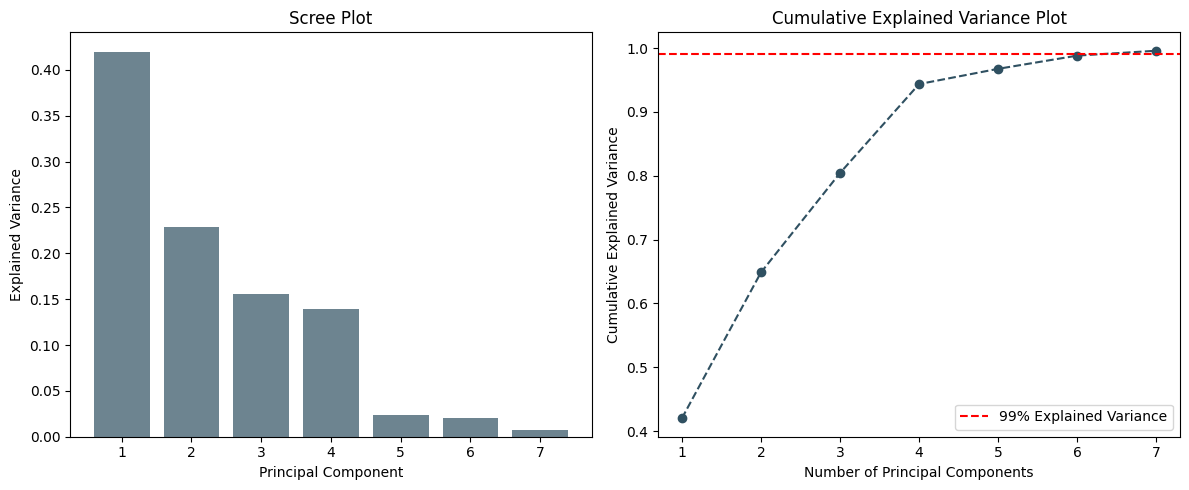

pc_df shape: (10029, 7)


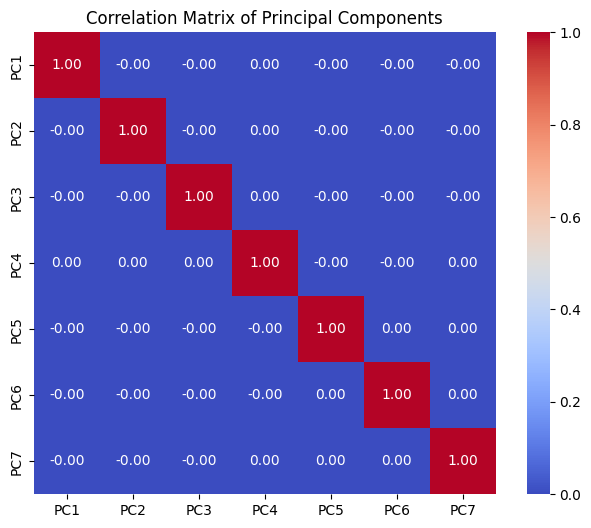

Added Flow Regime to pc_df_copy
Added Flow Regime to pc_df_copy2

PCA Loadings (feature contributions to each principal component):
                      PC1       PC2       PC3       PC4       PC5       PC6  \
G (kg/m2s)       0.059390 -0.449488 -0.235123  0.855782  0.080292  0.001874   
x                0.016809  0.001279  0.005294  0.013259 -0.159669  0.986305   
Tsat (K)         0.004147  0.007821 -0.007180  0.019771 -0.074329  0.010677   
rho_l           -0.037698 -0.295356  0.366264 -0.048053 -0.048106 -0.017293   
rho_v            0.587208 -0.178000  0.373323 -0.031422 -0.069122 -0.030326   
mu_l            -0.240371 -0.204999  0.219455 -0.027391 -0.053638 -0.013744   
mu_v             0.103020 -0.103123  0.154963 -0.011913 -0.024973 -0.011690   
k_v              0.105373  0.157962 -0.193373  0.033250 -0.158382 -0.032674   
k_l             -0.030311  0.065783 -0.103576 -0.027468  0.478808  0.078663   
surface_tension -0.389998 -0.128909  0.056733 -0.093585  0.643899  0.106725   

In [ ]:
refdata_log = refdata_filtered.copy()
features_to_transform = [col for col in refdata_log.columns 
                        if col not in ["h (W/m2K)", "x", "Z"] and col != "Glide_Temp"]

print("Applying log transformation to:", features_to_transform)

for col in features_to_transform:
    refdata_log[col] = np.log(refdata_log[col])
    print(f"Applied log transformation to {col}")

print(f"Data shape before dropping NaN: {refdata_log.shape}")
refdata_log_clean = refdata_log.dropna()
print(f"Data shape after dropping NaN: {refdata_log_clean.shape}")
X_df = refdata_log_clean.drop(columns=["h (W/m2K)"])
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_df)

joblib.dump(pca, 'pca_updated_model.pkl')
print("PCA model saved as pca_updated_model.pkl")
pc_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(7)])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nPCA Results:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: {var:.4f} ({cum_var:.4f} cumulative)")

# Scree Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='#2f5061')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))

# Cumulative Explained Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='#2f5061')
plt.title('Cumulative Explained Variance Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

print(f"pc_df shape: {pc_df.shape}")
corr_matrix_pc = pc_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_pc, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Principal Components')
plt.show()

pc_df_copy = pc_df.copy()
pc_df_copy2 = pc_df.copy()
pc_df_copy = pc_df_copy.reset_index(drop=True)
pc_df_copy2 = pc_df_copy2.reset_index(drop=True)

if 'dataset' in locals() or 'dataset' in globals():
    dataset = dataset.reset_index(drop=True)
    pc_df_copy['Flow Regime'] = dataset['Flow_Regime']
    print("Added Flow Regime to pc_df_copy")

if 'dataset_copy' in locals() or 'dataset_copy' in globals():
    dataset_copy = dataset_copy.reset_index(drop=True)
    pc_df_copy2['Flow Regime'] = dataset_copy['Flow_Regime']
    print("Added Flow Regime to pc_df_copy2")

feature_names = X_df.columns
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, index=feature_names, 
                           columns=[f'PC{i+1}' for i in range(loadings.shape[0])])
print("\nPCA Loadings (feature contributions to each principal component):")
print(loadings_df)    

In [19]:
feature_means = X_df.mean()  

pc_formulas_centered = {}
for pc in loadings_df.columns:
    terms = [
        f"{loadings_df.loc[feat, pc]:.4f}*({feat} - {feature_means[feat]:.4f})"
        for feat in loadings_df.index
    ]
    formula = " + ".join(terms)
    pc_formulas_centered[pc] = formula

for pc, formula in pc_formulas_centered.items():
    print(f"{pc} = {formula}\n")


PC1 = 0.0594*(G (kg/m2s) - 5.5515) + 0.0168*(x - 0.4790) + 0.0041*(Tsat (K) - 5.7390) + -0.0377*(rho_l - 6.7792) + 0.5872*(rho_v - 3.7916) + -0.2404*(mu_l - -8.9833) + 0.1030*(mu_v - -11.3520) + 0.1054*(k_v - -4.0766) + -0.0303*(k_l - -2.5234) + -0.3900*(surface_tension - -5.2256) + 0.1373*(Cp_v - 7.2765) + 0.0776*(Cp_l - 7.5145) + 0.0019*(Z - 0.0044) + 0.6111*(Psat (Pa) - 13.9490) + -0.1381*(D (m) - -5.2711)

PC2 = -0.4495*(G (kg/m2s) - 5.5515) + 0.0013*(x - 0.4790) + 0.0078*(Tsat (K) - 5.7390) + -0.2954*(rho_l - 6.7792) + -0.1780*(rho_v - 3.7916) + -0.2050*(mu_l - -8.9833) + -0.1031*(mu_v - -11.3520) + 0.1580*(k_v - -4.0766) + 0.0658*(k_l - -2.5234) + -0.1289*(surface_tension - -5.2256) + 0.2894*(Cp_v - 7.2765) + 0.2646*(Cp_l - 7.5145) + 0.0039*(Z - 0.0044) + 0.0749*(Psat (Pa) - 13.9490) + 0.6488*(D (m) - -5.2711)

PC3 = -0.2351*(G (kg/m2s) - 5.5515) + 0.0053*(x - 0.4790) + -0.0072*(Tsat (K) - 5.7390) + 0.3663*(rho_l - 6.7792) + 0.3733*(rho_v - 3.7916) + 0.2195*(mu_l - -8.9833) + 0.1

In [328]:
 refdata_log_clean.head()

,G (kg/m2s),x,h (W/m2K),Tsat (K),rho_l,rho_v,mu_l,mu_v,k_v,k_l,surface_tension,Cp_v,Cp_l,Z,Psat (Pa),D (m)
9561,5.398163,0.11,325.23,5.746682,6.871939,4.629903,-9.183803,-11.219219,-3.877759,-2.870459,-5.896201,7.311449,7.451769,0.000459,14.418819,-6.437752
4789,3.912023,0.01,334.00,5.610021,6.832419,4.581362,-9.206343,-11.137159,-3.892190,-2.215041,-5.407346,7.530885,7.840828,0.000000,15.064019,-5.032881
4878,3.912023,0.01,336.00,5.610021,6.832419,4.581362,-9.206343,-11.137159,-3.892190,-2.215041,-5.407346,7.530885,7.840828,0.000000,15.064019,-5.032881
1022,5.030438,0.01,348.29,5.705281,6.940145,4.257734,-8.993856,-11.297265,-4.043552,-2.784041,-5.473982,7.136735,7.354493,0.000036,14.102427,-4.828314
9470,6.025866,0.05,352.27,5.746682,7.044678,3.913722,-8.731324,-11.299994,-4.170386,-2.594065,-5.097023,7.042729,7.312159,0.000000,13.831966,-6.437752


## Skopt Model

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Y_xgb_skopt = np.log(refdata_log_clean['h (W/m2K)'])  # Target variable
X_xgb_skopt = pc_df  # Feature set 

# Train-test split
X_train_xgb_skopt, X_test_xgb_skopt, Y_train_xgb_skopt, Y_test_original_xgb = train_test_split(
    X_xgb_skopt, Y_xgb_skopt,
    test_size=0.2,
    random_state=RANDOM_STATE
)

#  cross-validation 
kf_skopt = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# search space
search_space = [
    Integer(100, 500, name='n_estimators'),
    Integer(3, 15, name='max_depth'),
    Real(0.01, 0.3, name='learning_rate'),
    Real(0.5, 1.0, name='subsample'),
    Real(0.5, 1.0, name='colsample_bytree'),
    Real(0, 1, name='gamma')
]

# objective function 
@use_named_args(search_space)
def objective(n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma):
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # 5-fold cross-validation 
    scores = cross_val_score(model, X_train_xgb_skopt, Y_train_xgb_skopt, cv=kf_skopt, scoring='r2', n_jobs=-1)
    mean_r2 = np.mean(scores)  
    return -mean_r2

start_time = time.time()
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=100,
    random_state=RANDOM_STATE
)
end_time = time.time()
elapsed_time = end_time - start_time

best_params_skopt = {
    'n_estimators': result.x[0],
    'max_depth': result.x[1],
    'learning_rate': result.x[2],
    'subsample': result.x[3],
    'colsample_bytree': result.x[4],
    'gamma': result.x[5]
}

print(f'Best Hyperparameters for XGBoost: {best_params_skopt}')

best_model_xgb_skopt = XGBRegressor(
    **best_params_skopt,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
best_model_xgb_skopt.fit(X_train_xgb_skopt, Y_train_xgb_skopt)

# Predictions and evaluations
Y_pred_xgb = best_model_xgb_skopt.predict(X_test_xgb_skopt)
Y_pred_train_xgb_skopt = best_model_xgb_skopt.predict(X_train_xgb_skopt)

# Reversing log transformation
Y_test_original_xgb = np.exp(Y_test_original_xgb)
Y_pred_exp_xgb = np.exp(Y_pred_xgb)
Y_train_exp_xgb_skopt = np.exp(Y_train_xgb_skopt)
Y_pred_exp_train_xgb_skopt = np.exp(Y_pred_train_xgb_skopt)

# R² and MAPE
r2_test_skopt = r2_score(Y_test_original_xgb, Y_pred_exp_xgb)
mape_test_skopt = mean_absolute_percentage_error(Y_test_original_xgb, Y_pred_exp_xgb)
r2_train_skopt = r2_score(Y_train_exp_xgb_skopt, Y_pred_exp_train_xgb_skopt)
rmse_test_xgb_hopt = np.sqrt(mean_squared_error(Y_test_original_xgb, Y_pred_exp_xgb))
print(f'Test RMSE: {rmse_test_xgb_hopt:.4f} W/m²K')
print(f'Test R²: {r2_test_skopt:.4f}')
print(f'Test MAPE: {mape_test_skopt:.4f}')
print(f'Training R²: {r2_train_skopt:.4f}')

comparison_df_test = pd.DataFrame({
    'Experimental_h (W/m2K)': Y_test_original_xgb,
    'Predicted_h (W/m2K)': Y_pred_exp_xgb
})
comparison_df_train = pd.DataFrame({
    'Experimental_h (W/m2K)': Y_train_exp_xgb_skopt,
    'Predicted_h (W/m2K)': Y_pred_exp_train_xgb_skopt
})
comparison_df_test.to_csv(r'C:\Users\Other User\Downloads\heat_transfer_comparison_skopt_test.csv', index=False)
comparison_df_train.to_csv(r'C:\Users\Other User\Downloads\heat_transfer_comparison_skopt_train.csv', index=False)

joblib.dump(best_model_xgb_skopt, 'best_xgboost_model_skopt.pkl')
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f'Total calculation time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds')

Best Hyperparameters for XGBoost: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.17336951707054696, 'subsample': 1.0, 'colsample_bytree': 0.8221474762517419, 'gamma': 0.0}
Test RMSE: 599.1067 W/m²K
Test R²: 0.9441
Test MAPE: 0.0840
Training R²: 0.9983
Total calculation time: 0 hours, 2 minutes, 49.21 seconds


## Plots

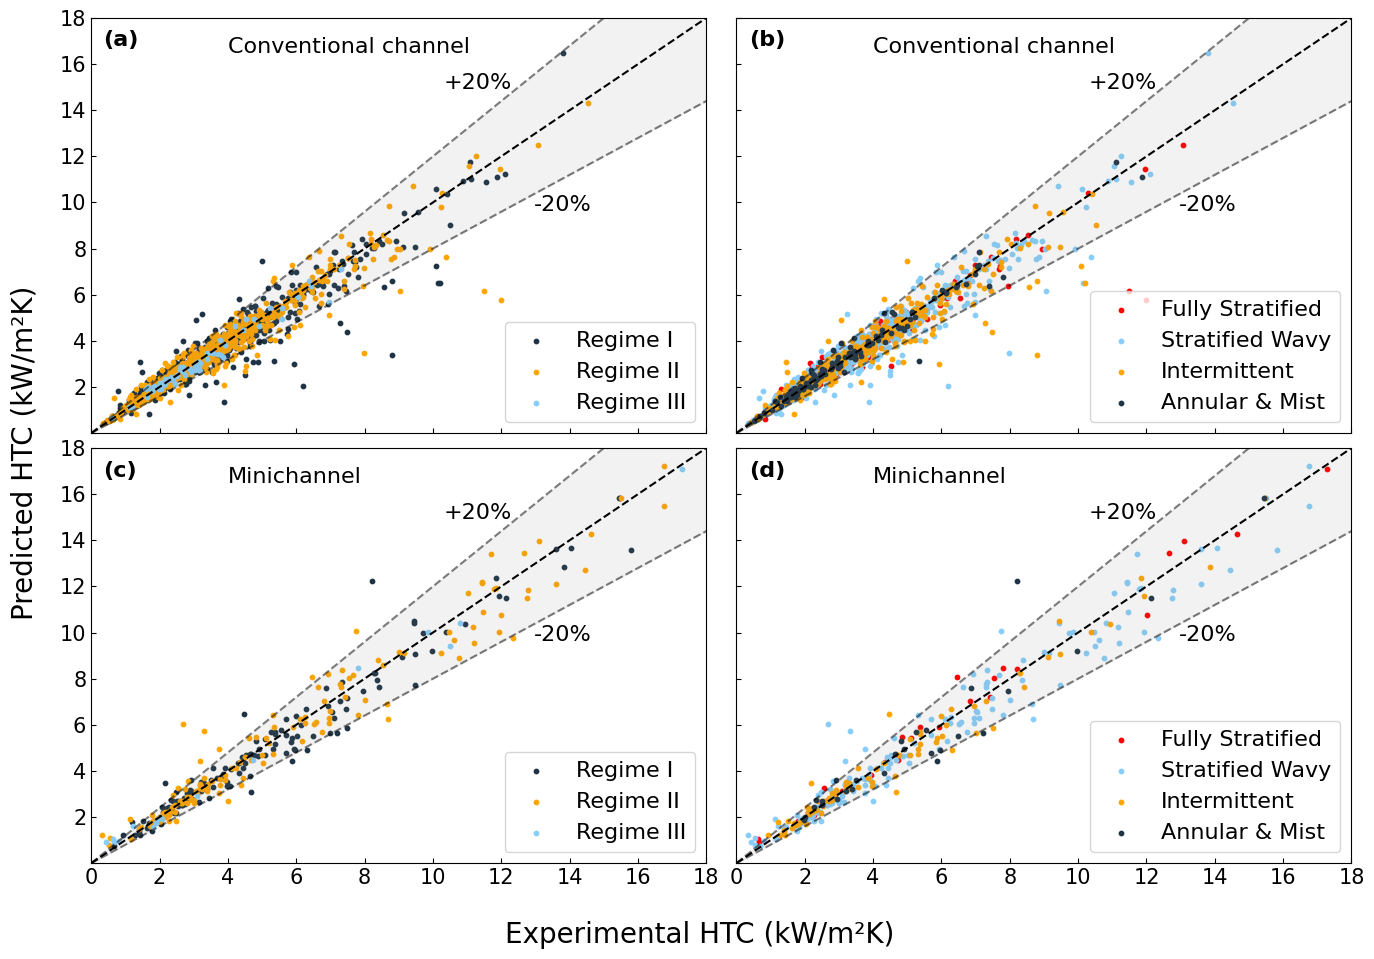

Scatter plot saved to C:\Users\Other User\Downloads\scatter_plot_regimes.png


In [ ]:
# Google Sheet
sheet_url = 'https://docs.google.com/spreadsheets/d/1UjYTErdli11kSe6ZmcpBf_x1jW_bNUDQc1VSOjmUFz0/edit#gid=0'
csv_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
data = pd.read_csv(csv_url, skiprows=3)

# W/m²K to kW/m²K
data /= 1000

fontsize_labels = 20
fontsize_ticks = 15
fontsize_annotations = 16
fontsize_legend = 16
fontsize_deviation = 16
fontsize_channel_label = 16

column_groups = {
    'Plot 1 (Conventional - Regimes I, II, III)': [0, 2, 4],
    'Plot 2 (Conventional - Flow Types)': [6, 8, 10, 12],
    'Plot 3 (Minichannels - Regimes I, II, III)': [14, 16, 18],
    'Plot 4 (Minichannels - Flow Types)': [20, 22, 24, 26]
}

regime_labels = {
    'Plot 1': ['Regime I', 'Regime II', 'Regime III'],
    'Plot 2': ['Fully Stratified', 'Stratified Wavy', 'Intermittent', 'Annular & Mist'],
    'Plot 3': ['Regime I', 'Regime II', 'Regime III'],
    'Plot 4': ['Fully Stratified', 'Stratified Wavy', 'Intermittent', 'Annular & Mist']
}

regime_colors = {
    'Plot 1': ['#1e3446', 'orange', '#87cefa'],
    'Plot 2': ['red', '#87cefa', 'orange', '#1e3446'],
    'Plot 3': ['#1e3446', 'orange', '#87cefa'],
    'Plot 4': ['red', '#87cefa', 'orange', '#1e3446']
}

channel_labels = ['Conventional channel', 'Conventional channel', 'Minichannel', 'Minichannel']

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

x_limit = [0, 18]
y_limit = [0, 18]

def clean_tick_labels(val, _):
    return f"{int(val)}" if val == int(val) else f"{val:.1f}"

def clean_y_tick_labels(val, _):
    return "" if abs(val) < 1e-6 else (f"{int(val)}" if val == int(val) else f"{val:.1f}")

def plot_scatter(ax, columns, labels, annotate, channel_label, plot_colors):
    for i, col in enumerate(columns):
        experimental = data.iloc[:, col]
        predicted = data.iloc[:, col + 1]
        ax.scatter(experimental, predicted, s=10, color=plot_colors[i], label=labels[i])
    
    ax.plot(x_limit, y_limit, 'k--')
    ax.plot(x_limit, [y * 1.2 for y in y_limit], 'k--', alpha=0.5)
    ax.plot(x_limit, [y * 0.8 for y in y_limit], 'k--', alpha=0.5)

    ax.text(11.3, 15.2, '+20%', fontsize=fontsize_deviation, color='black',
            rotation=0, ha='center', va='center')
    ax.text(13.8, 9.9, '-20%', fontsize=fontsize_deviation, color='black',
            rotation=0, ha='center', va='center')

    x_vals = np.linspace(x_limit[0], x_limit[1], 200)
    ax.fill_between(x_vals, x_vals * 0.8, x_vals * 1.2, color='gray', alpha=0.1)
    
    ax.tick_params(axis='both', which='both', direction='in', labelsize=fontsize_ticks)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(clean_tick_labels))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(clean_y_tick_labels))
    
    ax.text(0.02, 0.97, annotate, transform=ax.transAxes, fontsize=fontsize_annotations,
            fontweight='bold', va='top', ha='left')
    ax.text(4, 16.5, channel_label, fontsize=fontsize_channel_label, color='black')

subplot_labels = ['(a)', '(b)', '(c)', '(d)']

for i, (title, cols) in enumerate(column_groups.items()):
    row, col = divmod(i, 2)
    plot_scatter(axs[row, col], cols, regime_labels[f'Plot {i+1}'], 
                 subplot_labels[i], channel_labels[i], regime_colors[f'Plot {i+1}'])
    axs[row, col].legend(loc='lower right', fontsize=fontsize_legend, frameon=True)

fig.text(0.5, 0.01, 'Experimental HTC (kW/m²K)', ha='center', fontsize=fontsize_labels)
fig.text(0.04, 0.5, 'Predicted HTC (kW/m²K)', va='center', rotation='vertical', fontsize=fontsize_labels)

for ax in axs.flat:
    ax.set_xlim(x_limit)
    ax.set_ylim(y_limit)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()

save_path = r'C:\Users\Other User\Downloads\scatter_plot_regimes.png'
save_path2 = r'C:\Users\Other User\Downloads\scatter_plot_regimes.pdf'
fig.savefig(save_path, dpi=800)
fig.savefig(save_path2, dpi=600)
print(f'Scatter plot saved to {save_path}')

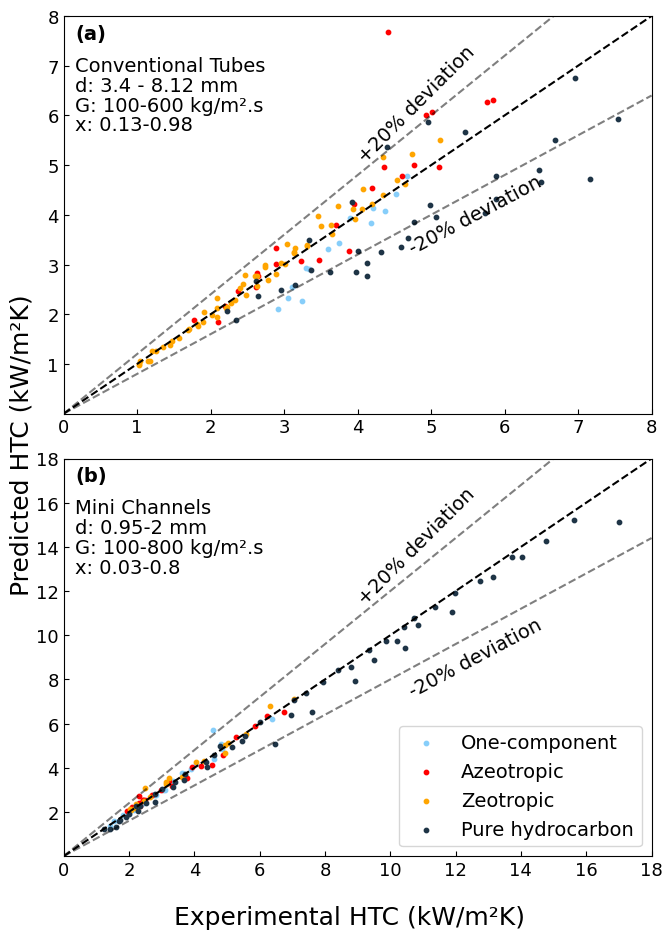

Scatter plot saved to C:\Users\Other User\Downloads\scatter_plot_channels.pdf


In [7]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1zqJFb8Fd6z2OOzb1Tt7Lv8RWMTa-bel_rYXuj1i3EoE/edit?gid=1753864350#gid=1753864350'
csv_url = sheet_url.replace('/edit?gid=', '/export?format=csv&gid=').split('#')[0]
data = pd.read_csv(csv_url)
data_kW = data / 1000

# experimental data
experimental = data_kW.iloc[:, 0]

plots = [
    ('Conventional Channel', 1, 5, 8, ['One-component', 'Azeotropic', 'Zeotropic', 'Pure hydrocarbon']),
    ('Mini Channel', 5, 9, 18, ['One-component', 'Azeotropic', 'Zeotropic', 'Pure hydrocarbon'])
]

colors = [
    '#87cefa',
    'red',
    'orange',    
    '#1e3446' 
       
]

xlabel_fontsize = 18
ylabel_fontsize = 18
deviation_fontsize = 14
tick_fontsize = 13
annotation_fontsize = 14
legend_fontsize = 14

fig, axs = plt.subplots(2, 1, figsize=(7.3, 10), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.2)  # Adjust space between the plots

def clean_tick_labels(val, _):
    return f"{int(val)}" if val == int(val) else f"{val:.1f}"

for i, (title, start_col, end_col, limit, legend_labels) in enumerate(plots):
    ax = axs[i]

    predicted_data = data_kW.iloc[:, start_col:end_col]
    for j, col_name in enumerate(predicted_data.columns):
        ax.scatter(experimental, predicted_data[col_name], s=10, color=colors[j], label=legend_labels[j])

    ax.plot([0, limit], [0, limit], 'k--')
    ax.plot([0, limit], [0, limit * 1.2], 'k--', alpha=0.5)
    ax.plot([0, limit], [0, limit * 0.8], 'k--', alpha=0.5)
    ax.text(limit * 0.6, limit * 0.78, '+20% deviation', fontsize=deviation_fontsize, color='black', rotation=45, ha='center', va='center')
    ax.text(limit * 0.7, limit * 0.5, '-20% deviation', fontsize=deviation_fontsize, color='black', rotation=28, ha='center', va='center')
    ax.text(0.02, 0.98, f'({chr(97 + i)})', fontsize=annotation_fontsize, fontweight='bold', transform=ax.transAxes, va='top', ha='left')
    if i == 0:  
        ax.text(0.02, 0.90, 'Conventional Tubes', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
        ax.text(0.02, 0.85, 'd: 3.4 - 8.12 mm', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
        ax.text(0.02, 0.80, 'G: 100-600 kg/m².s', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
        ax.text(0.02, 0.75, 'x: 0.13-0.98', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
    elif i == 1:  
        ax.text(0.02, 0.90, 'Mini Channels', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
        ax.text(0.02, 0.85, 'd: 0.95-2 mm', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
        ax.text(0.02, 0.80, 'G: 100-800 kg/m².s', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
        ax.text(0.02, 0.75, 'x: 0.03-0.8', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')

    ax.tick_params(axis='both', which='both', direction='in', labelsize=tick_fontsize)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(clean_tick_labels))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(clean_tick_labels))
    ax.set_xlim([0, limit])
    ax.set_ylim([0, limit])
    if i == 1:
        ax.legend(loc='lower right', fontsize=legend_fontsize, frameon=True)

fig.text(0.5, 0.02, 'Experimental HTC (kW/m²K)', ha='center', fontsize=xlabel_fontsize)
fig.text(0.035, 0.5, 'Predicted HTC (kW/m²K)', va='center', rotation='vertical', fontsize=ylabel_fontsize)

for ax in axs:
 current_yticks = ax.get_yticks()
 new_yticks = [tick for tick in current_yticks if tick != 0]
 ax.set_yticks(new_yticks)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()
save_path = r'C:\Users\Other User\Downloads\scatter_plot_channels.pdf'
fig.savefig(save_path, dpi=800)
print(f'Scatter plot saved to {save_path}')

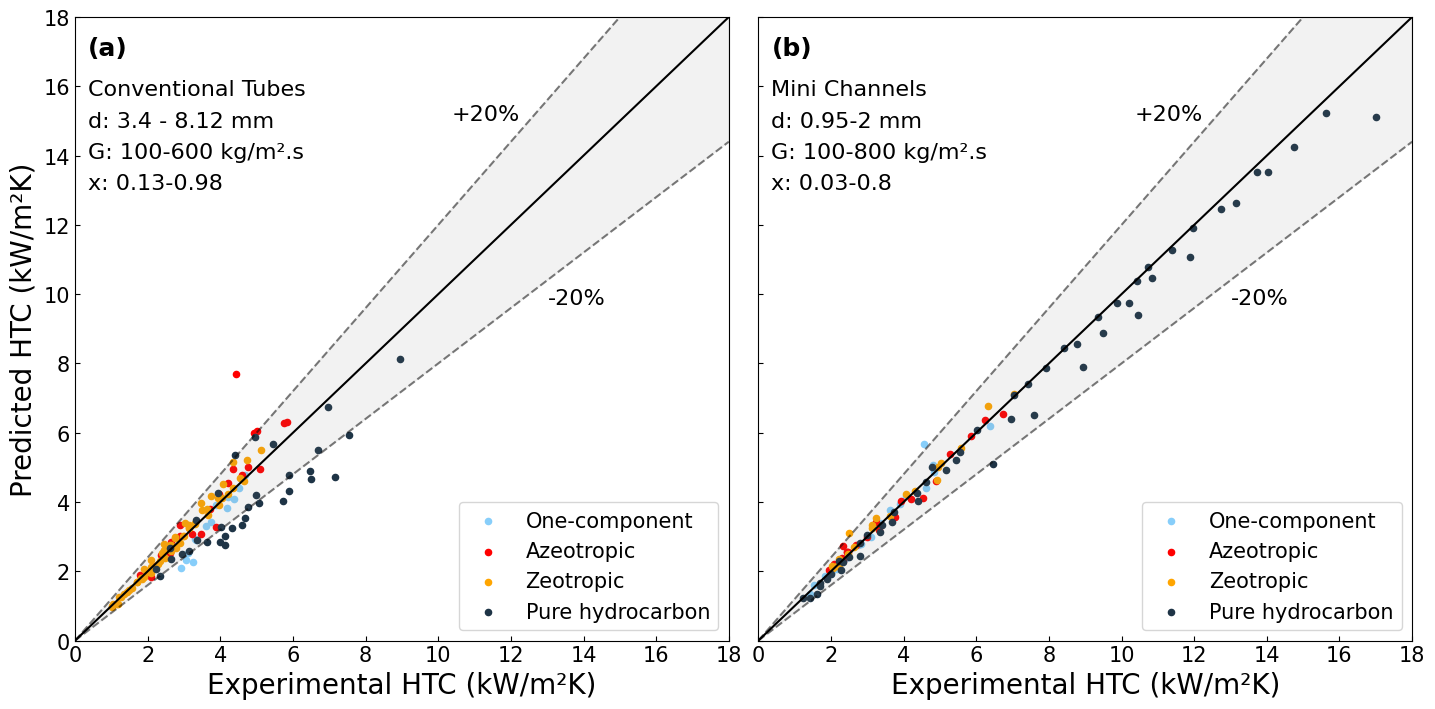

Scatter plot saved to C:\Users\Other User\Downloads\scatter_plot_channels.pdf


In [6]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1zqJFb8Fd6z2OOzb1Tt7Lv8RWMTa-bel_rYXuj1i3EoE/export?format=csv'
data = pd.read_csv(sheet_url)
experimental = data.iloc[:, 0] / 1000
conv_predicted = data.iloc[:, 1:5] / 1000  # Conventional channels predictions
mini_predicted = data.iloc[:, 5:9] / 1000  # Mini channel predictions

legend_labels = ['One-component', 'Azeotropic', 'Zeotropic', 'Pure hydrocarbon']
colors = ['#87cefa', 'red', 'orange', '#1e3446']
xlabel_fontsize = 20  
ylabel_fontsize = 20  
annotation_fontsize = 16
tick_fontsize = 15  
x_limit = [0, 18]
y_limit = [0, 18]

fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.25)

x_vals = np.linspace(x_limit[0], x_limit[1], 500)
ax = axs[0]
for j, col_name in enumerate(conv_predicted.columns):
    ax.scatter(experimental, conv_predicted[col_name], s=20, color=colors[j], label=legend_labels[j])


ax.plot(x_limit, y_limit, 'k')
ax.plot(x_vals, x_vals*1.2, 'k--', alpha=0.5)
ax.plot(x_vals, x_vals*0.8, 'k--', alpha=0.5)
ax.fill_between(x_vals, x_vals*0.8, x_vals*1.2, color='gray', alpha=0.1)
ax.text(0.02, 0.90, 'Conventional Tubes', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
ax.text(0.02, 0.85, 'd: 3.4 - 8.12 mm', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
ax.text(0.02, 0.80, 'G: 100-600 kg/m².s', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
ax.text(0.02, 0.75, 'x: 0.13-0.98', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
ax.text(11.3, 15.2, '+20%', fontsize=annotation_fontsize, ha='center', va='center')
ax.text(13.8, 9.9, '-20%', fontsize=annotation_fontsize, ha='center', va='center')
ax.text(0.02, 0.97, '(a)', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
ax.set_xlabel('Experimental HTC (kW/m²K)', fontsize=xlabel_fontsize)
ax.set_ylabel('Predicted HTC (kW/m²K)', fontsize=ylabel_fontsize)
ax.legend(loc='lower right', fontsize=tick_fontsize, frameon=True)
ax.tick_params(axis='both', direction='in', labelsize=tick_fontsize)


ax = axs[1]
for j, col_name in enumerate(mini_predicted.columns):
    ax.scatter(experimental, mini_predicted[col_name], s=20, color=colors[j], label=legend_labels[j])
ax.plot(x_limit, y_limit, 'k')
ax.plot(x_vals, x_vals*1.2, 'k--', alpha=0.5)
ax.plot(x_vals, x_vals*0.8, 'k--', alpha=0.5)
ax.fill_between(x_vals, x_vals*0.8, x_vals*1.2, color='gray', alpha=0.1)
ax.text(0.02, 0.90, 'Mini Channels', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
ax.text(0.02, 0.85, 'd: 0.95-2 mm', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
ax.text(0.02, 0.80, 'G: 100-800 kg/m².s', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
ax.text(0.02, 0.75, 'x: 0.03-0.8', fontsize=annotation_fontsize, transform=ax.transAxes, va='top', ha='left')
ax.text(11.3, 15.2, '+20%', fontsize=annotation_fontsize, ha='center', va='center')
ax.text(13.8, 9.9, '-20%', fontsize=annotation_fontsize, ha='center', va='center')
ax.text(0.02, 0.97, '(b)', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
ax.set_xlabel('Experimental HTC (kW/m²K)', fontsize=xlabel_fontsize)
ax.legend(loc='lower right', fontsize=tick_fontsize, frameon=True)
ax.tick_params(axis='both', direction='in', labelsize=tick_fontsize)

for ax in axs:
    ax.set_xlim(x_limit)
    ax.set_ylim(y_limit)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda val, _: f"{int(val)}" if val == int(val) else f"{val:.1f}"))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, _: f"{int(val)}" if val == int(val) else f"{val:.1f}"))

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()
save_path = r'C:\Users\Other User\Downloads\scatter_plot_channels.pdf'
fig.savefig(save_path, dpi=600)
print(f'Scatter plot saved to {save_path}')

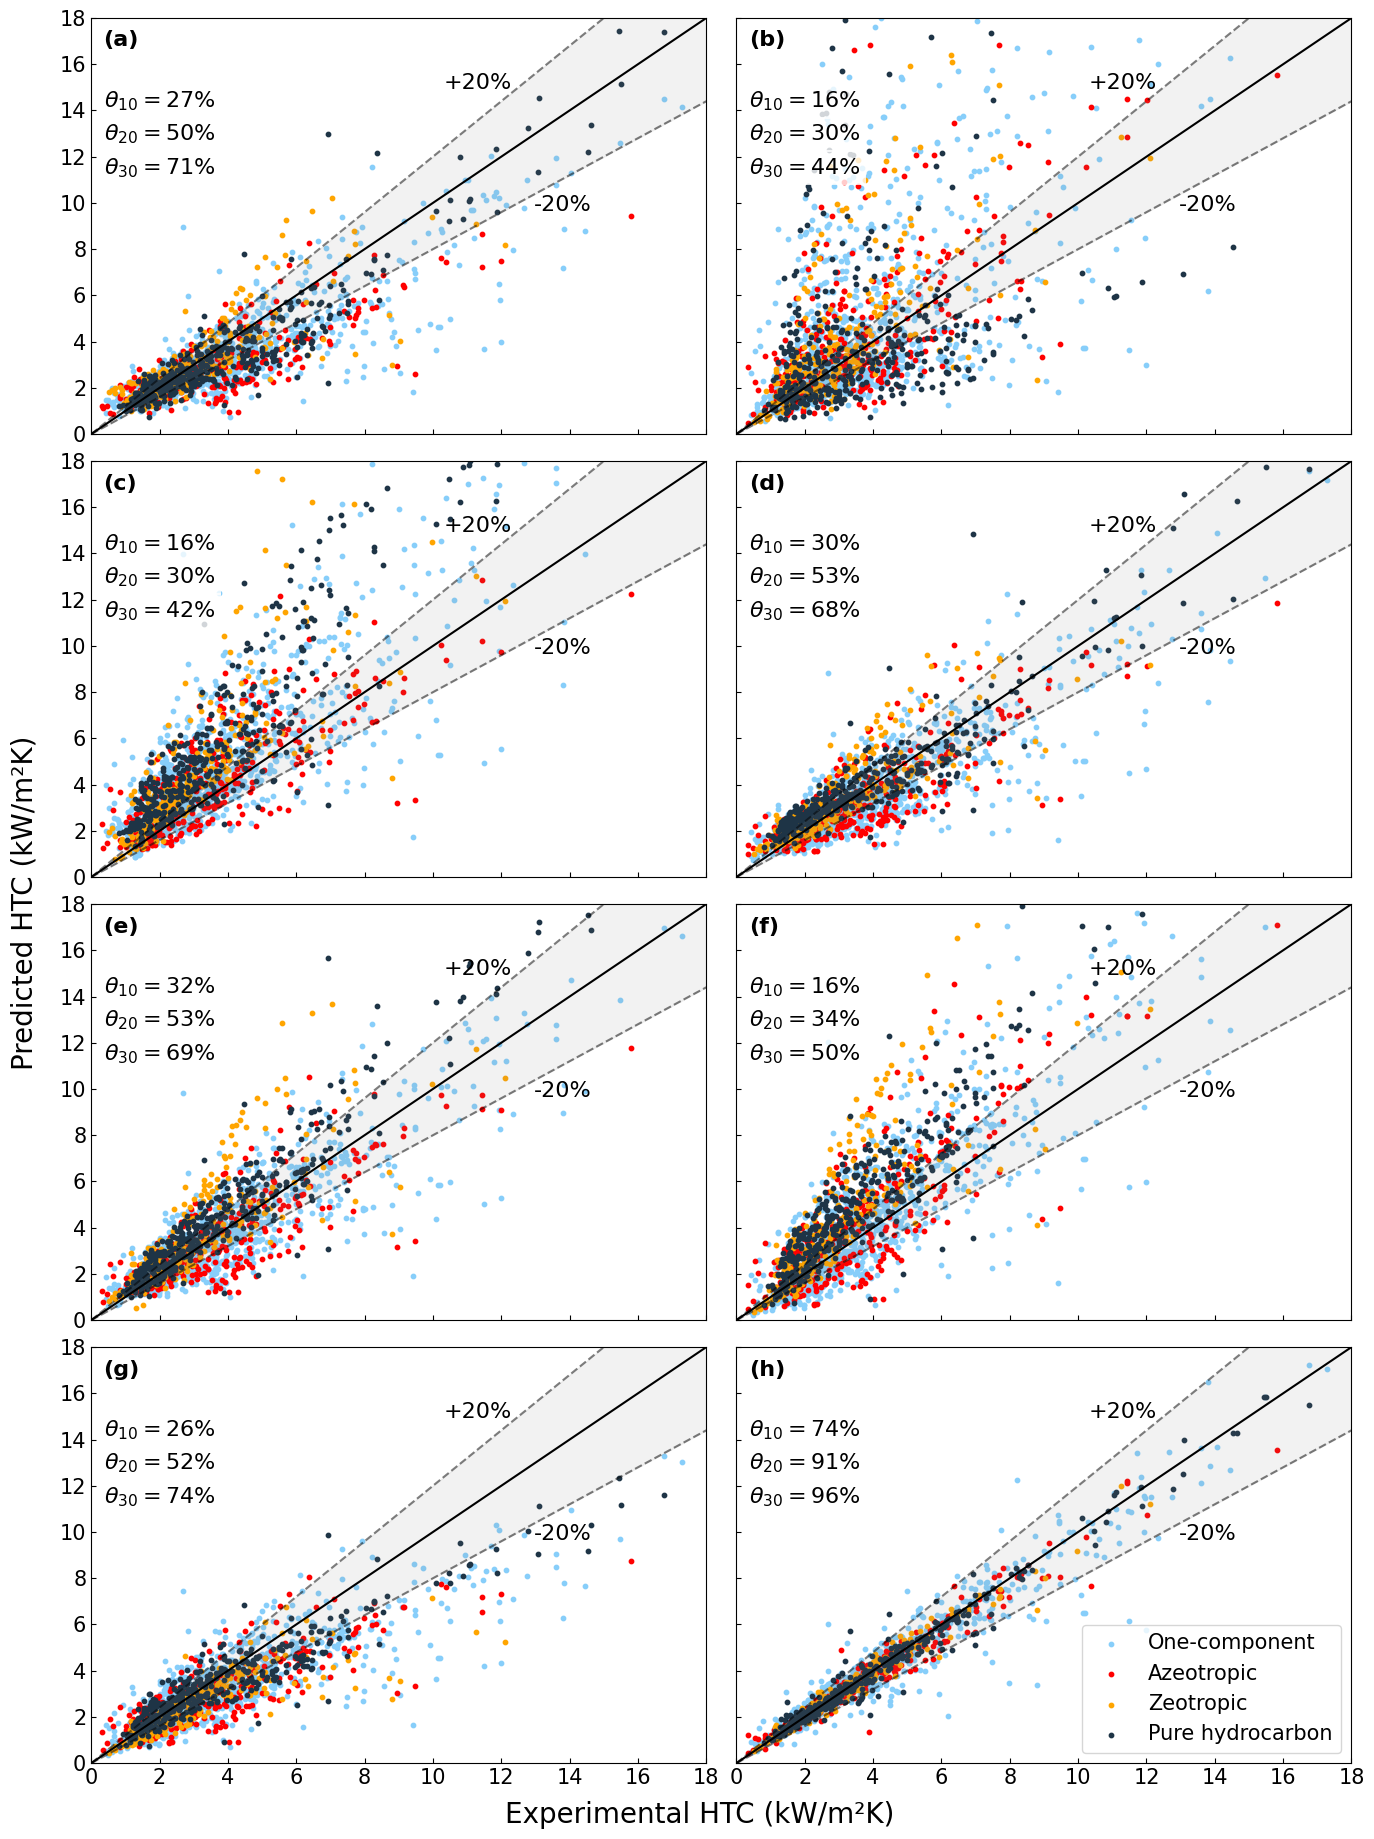

In [5]:
sheet_url = 'https://docs.google.com/spreadsheets/d/167t8UUXGE_2tjB3loSvV-tO2gUe3p9jIUGQqG_kwI2A/export?format=csv'
data = pd.read_csv(sheet_url)
experimental = data.iloc[:, 0] / 1000  

figures = [
    ('Nie et al. Correlation (2023)', 1, 5),
    ('Bohdal et al. Correlation (2011)', 5, 9),
    ('Kim & Mudawar Correlation (2013)', 9, 13),
    ('Dorao and Fernandino Correlation (2018)', 13, 17),
    ('Shah Correlation (2022)', 17, 21),
    ('Dobson & Chato Correlation (1998)', 21, 25),
    ('Marinheiro et al. Correlation (2024)', 25, 29),
    ('XGBoost Model', 29, 33)
]

subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
legend_labels = ['One-component', 'Azeotropic', 'Zeotropic', 'Pure hydrocarbon']
colors = ['#87cefa', 'red', 'orange', '#1e3446']
title_fontsize = 20  
xlabel_fontsize = 20  
ylabel_fontsize = 20  
fontsize_deviation = 16
tick_fontsize = 15  
subplot_label_fontsize = 16  
x_limit = [0, 18]  
y_limit = [0, 18]  

def clean_tick_labels(val, _):
    return f"{int(val)}" if val == int(val) else f"{val:.1f}"
def theta(exp, pred, perc):
    return 100 * np.sum(np.abs(pred - exp) / exp <= perc/100) / len(exp)

fig, axs = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, (title, start_col, end_col) in enumerate(figures):
    row, col = divmod(i, 2)
    ax = axs[row, col]
    predicted_cols = data.iloc[:, start_col:end_col] / 1000
    for j, col_name in enumerate(predicted_cols.columns):
        ax.scatter(experimental, predicted_cols[col_name], s=10, color=colors[j], label=legend_labels[j])
    x_vals = np.linspace(x_limit[0], x_limit[1], 500)
    ax.plot(x_limit, y_limit, 'k')
    ax.plot(x_limit, [y * 1.2 for y in y_limit], 'k--', alpha=0.5)
    ax.plot(x_limit, [y * 0.8 for y in y_limit], 'k--', alpha=0.5)
    ax.fill_between(x_vals, x_vals * 0.8, x_vals * 1.2, color='gray', alpha=0.1)
    ax.text(11.3, 15.2, '+20%', fontsize=fontsize_deviation, color='black', ha='center', va='center')
    ax.text(13.8, 9.9, '-20%', fontsize=fontsize_deviation, color='black', ha='center', va='center')
    pred_mean = predicted_cols.mean(axis=1)
    theta_10 = theta(experimental, pred_mean, 10)
    theta_20 = theta(experimental, pred_mean, 20)
    theta_30 = theta(experimental, pred_mean, 30)
    ax.text(0.02, 0.8, rf'$\theta_{{10}} = {theta_10:.0f}\%$', fontsize=fontsize_deviation,
            transform=ax.transAxes, ha='left', va='center',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    ax.text(0.02, 0.72, rf'$\theta_{{20}} = {theta_20:.0f}\%$', fontsize=fontsize_deviation,
            transform=ax.transAxes, ha='left', va='center',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    ax.text(0.02, 0.64, rf'$\theta_{{30}} = {theta_30:.0f}\%$', fontsize=fontsize_deviation,
            transform=ax.transAxes, ha='left', va='center',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    ax.text(0.02, 0.97, subplot_labels[i], fontsize=subplot_label_fontsize, transform=ax.transAxes, fontweight='bold', va='top', ha='left')
    ax.tick_params(axis='both', direction='in', labelsize=tick_fontsize)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(clean_tick_labels))  
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(clean_tick_labels))  
    if i == len(figures) - 1:
        ax.legend(loc='lower right', fontsize=tick_fontsize, frameon=True)

fig.text(0.5, 0.04, 'Experimental HTC (kW/m²K)', ha='center', fontsize=xlabel_fontsize)
fig.text(0.04, 0.5, 'Predicted HTC (kW/m²K)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
for ax in axs.flat:
    ax.set_xlim(x_limit)
    ax.set_ylim(y_limit)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
fig.savefig(r'C:\Users\Other User\Downloads\scatter_plot.png', dpi=800)
fig.savefig(r'C:\Users\Other User\Downloads\scatter_plot.pdf', dpi=800)
plt.show()
